In [18]:
#loading in req. packages
import mne
import matplotlib.pyplot as plt
import os
import numpy as np
import os.path as op
import warnings
from mne_bids import (
    BIDSPath,
    make_dataset_description,
    print_dir_tree,
    read_raw_bids,
)
from mne.preprocessing import find_bad_channels_maxwell
from mne import epochs

import sys
import scipy
import pprint


In [4]:
out_dir = '/work/Reka_Clara/data/ds005107/derivatives/epochs'

fig_dir = "/work/Reka_Clara/reka/figures_preprocessing"
os.makedirs(fig_dir, exist_ok=True)

In [7]:

def detect_bad_channels_psd(raw):
    psds, freqs = raw.compute_psd(fmin=0.1, fmax=150, method='welch').get_data(return_freqs=True)
    median_psd = np.median(psds, axis=0)
    relative_power = psds / median_psd
    total_power = psds.sum(axis=1)
    threshold = np.median(total_power) * 4 
    bad_chs = [ch for ch, p in zip(raw.ch_names, total_power) if p > threshold]
    return bad_chs

def detect_flat_channels(raw, std_thresh=1e-12):
    flat_chs = [ch for ch, data in zip(raw.ch_names, raw.get_data())
                if np.std(data) < std_thresh]
    return flat_chs

In [33]:
def preprocess(raw, subject=None, session=None, run=None):
    
    raw = raw.load_data()
    raw.info['line_freq'] = 50.0
    
    n_ch_start = len(raw.ch_names)

    raw_cropped = raw.copy()

    events = mne.find_events(raw_cropped)

      
    #Detect bad channels
    auto_bads_psd = detect_bad_channels_psd(raw_cropped)
    auto_bads_flat = detect_flat_channels(raw_cropped)
    bads = sorted(set(auto_bads_psd + auto_bads_flat))
    
    raw_cropped.info["bads"] = bads
    
    print(f"[BadCh] sub-{subject} ses-{session} run-{run}: "
          f"flagged {len(bads)}/{n_ch_start} bad channels\n    {bads}")

    picks = mne.pick_types(raw_cropped.info, meg=True, exclude=())

    #print out psd plot before any more processing
    n_fft = 2000 # achieving a 0.5 Hz frequency resolution
    psd_before = raw_cropped.compute_psd('welch', fmin=0.0, fmax=100, picks=picks, n_fft=n_fft, n_overlap=int(n_fft // 2))  

    fig_psd_before = psd_before.plot(show=False)
    fig_psd_before.suptitle(f"PSD before filtering – sub-{subject} ses-{session} run-{run}")

    fname_before = f"sub-{subject}_ses-{session}_run-{run}_psd_before.png"
    fig_psd_before.savefig(os.path.join(fig_dir, fname_before), dpi=150)
    plt.close(fig_psd_before)




    #Notch filtering
    raw_cropped.notch_filter(np.arange(50, 251, 50), notch_widths=1)

    # second notch filter for 44 Hz line noise from the stimulator
    raw_cropped.notch_filter(44, notch_widths=1)

    
    #bandpass filtering
    raw_cropped.filter(l_freq=0.1, h_freq=100.0)


    psd_after = raw_cropped.compute_psd('welch', fmin=0.0, fmax=100, picks=picks, n_fft=n_fft, n_overlap=int(n_fft // 2))  

    fig_psd_after = psd_after.plot(show=False)
    fig_psd_after.suptitle(f"PSD after filtering – sub-{subject} ses-{session} run-{run}")

    fname_after = f"sub-{subject}_ses-{session}_run-{run}_psd_after.png"
    fig_psd_after.savefig(os.path.join(fig_dir, fname_after), dpi=150)
    plt.close(fig_psd_after)


    #drop bad channels (can't interpolate without head digitalisation, so this is the only way it does not infect the data later on)

    #raw_cropped.drop_channels(bads)
    raw_clean = raw_cropped

    n_ch_final = len(raw_clean.ch_names)
    print(f"[Chan] sub-{subject} ses-{session} run-{run}: "
          f"kept {n_ch_final}/{n_ch_start} channels "
          f"(dropped {len(bads)})")

    stats = dict(
        subject=subject,
        session=session,
        run=run,
        n_channels_start=n_ch_start,
        n_bad=len(bads),
        bad_channels=";".join(bads),
        n_channels_final=n_ch_final)


    return raw_clean, stats

In [34]:
#load in all files, from all subjects and all sessions
preproc_stats = []
clean_raw = []  # store all processed raw objects here
data_path = '/work/Reka_Clara/data/ds005107/'

subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
sessions = ['01', '02']
runs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

for subject in subjects:
    for session in sessions:
        for run in runs:

            bids_path = BIDSPath(
                subject=subject,
                session=session,
                task='face',
                run=run,
                suffix='meg',
                extension='.fif',
                root=data_path
            )

            meg_dir = os.path.join(bids_path.directory, 'derivatives', 'mne-clean')
            out_fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-clean_meg.fif"
            out_path  = os.path.join(meg_dir, out_fname)

            print(f'Processing subject {subject}, session {session}, run {run}...')

            #if os.path.exists(out_path):
             #   print(f'Clean file exists, skipping: {out_path}')
              #  continue

            try:
                raw = read_raw_bids(bids_path=bids_path, verbose=False)
                raw_clean, stats = preprocess(raw, subject=subject, session=session, run=run)
                preproc_stats.append(stats)

                os.makedirs(meg_dir, exist_ok=True)
                raw_clean.save(out_path, overwrite=True)
                print(f'Saved preprocessed data to {out_path}')

                del raw
                del raw_clean

            except Exception as e:
                print(f'Could not process subject {subject}, session {session}, run {run}: {e}')

Processing subject 01, session 01, run 01...
Reading 0 ... 325339  =      0.000 ...   325.339 secs...


/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1J/0p/SHA256E-s84601620--67d9042189a96cc5e0ec779398e79d35abe3a8c35bf36bbeace49bcf6158afda.fif/SHA256E-s84601620--67d9042189a96cc5e0ec779398e79d35abe3a8c35bf36bbeace49bcf6158afda.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-01: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG58', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jm/Qm/SHA256E-s88260044--900490f106d0712480161eaebea2f14fc8109ba931b3b7589d0425538a07e39b.fif/SHA256E-s88260044--900490f106d0712480161eaebea2f14fc8109ba931b3b7589d0425538a07e39b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-02: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wj/zQ/SHA256E-s84156988--ec8dee819030a76302a662df9217c52c8051f5570fcf4d23af3f75aeec5328fa.fif/SHA256E-s84156988--ec8dee819030a76302a662df9217c52c8051f5570fcf4d23af3f75aeec5328fa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-03: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/k1/wz/SHA256E-s85459668--8eb3c3b0ea226fe428dcd2fc69eeb2fb4481124c49b4746b53d51d7614f6a39b.fif/SHA256E-s85459668--8eb3c3b0ea226fe428dcd2fc69eeb2fb4481124c49b4746b53d51d7614f6a39b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-04: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wv/G4/SHA256E-s84307804--f9dd229b587bfa5034050cf7911185dcedb377f1eb43f9ab970881ecbe1e62d5.fif/SHA256E-s84307804--f9dd229b587bfa5034050cf7911185dcedb377f1eb43f9ab970881ecbe1e62d5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-05: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xw/Pk/SHA256E-s83865772--0b976b59cd7c126c051dbbbe1b4db61afefc15c0a631541a0aec0b0d635b82f1.fif/SHA256E-s83865772--0b976b59cd7c126c051dbbbe1b4db61afefc15c0a631541a0aec0b0d635b82f1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-06: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wz/VV/SHA256E-s84393604--9eb47bc4cf1e9ae24caffd7341e6aa8c6d1ec8053a9e48a5da8da9eddc22c457.fif/SHA256E-s84393604--9eb47bc4cf1e9ae24caffd7341e6aa8c6d1ec8053a9e48a5da8da9eddc22c457.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-07: flagged 16/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4p/f4/SHA256E-s83792972--1fe6e4d32f7d27c609e0231a0620b690c31c4e9f4c5f9210b5d5259fd050e78e.fif/SHA256E-s83792972--1fe6e4d32f7d27c609e0231a0620b690c31c4e9f4c5f9210b5d5259fd050e78e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-08: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1m/XG/SHA256E-s84289604--8deaa8c250ed5653406f5a96a5a962cad51deee9116b00744d14e125961ecce6.fif/SHA256E-s84289604--8deaa8c250ed5653406f5a96a5a962cad51deee9116b00744d14e125961ecce6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-09: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wq/wW/SHA256E-s84229788--6a0b6d37e4b1bca0f192a8f57cefa187099c08213916b6bbd36f643c4f158257.fif/SHA256E-s84229788--6a0b6d37e4b1bca0f192a8f57cefa187099c08213916b6bbd36f643c4f158257.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-01 run-10: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qg/8J/SHA256E-s86003100--6e6d8a9d665aa7ac28069eb5b8454e9ed472920d55d6b5c009905db3c0647a02.fif/SHA256E-s86003100--6e6d8a9d665aa7ac28069eb5b8454e9ed472920d55d6b5c009905db3c0647a02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-01: flagged 13/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wq/45/SHA256E-s84078988--fb8e16fcc1bb2406ca0250e64ef8d1baf6f9b1dff4076427477a83e5ad1e1c67.fif/SHA256E-s84078988--fb8e16fcc1bb2406ca0250e64ef8d1baf6f9b1dff4076427477a83e5ad1e1c67.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-02: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zx/WJ/SHA256E-s84502804--61f5c3991208ea6f72b5faccee6e692bdb49b73dd109eeda0a3a440ef43dc872.fif/SHA256E-s84502804--61f5c3991208ea6f72b5faccee6e692bdb49b73dd109eeda0a3a440ef43dc872.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-03: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2P/kz/SHA256E-s82630692--66fb62120d87a5b3c6cfbfd2d1e19aa9ec9385e359d1a92a99efe3e8f5955b00.fif/SHA256E-s82630692--66fb62120d87a5b3c6cfbfd2d1e19aa9ec9385e359d1a92a99efe3e8f5955b00.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-04: flagged 17/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/ZX/K9/SHA256E-s83119524--f247d29103adf7a35002b9a64f56d88649c769eef476efee8db94ebd581f283c.fif/SHA256E-s83119524--f247d29103adf7a35002b9a64f56d88649c769eef476efee8db94ebd581f283c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-05: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4Z/9P/SHA256E-s82807508--84118edeae9e0bca316ab962d09dbdc2d0ffc376a99815d9627224256c4390b7.fif/SHA256E-s82807508--84118edeae9e0bca316ab962d09dbdc2d0ffc376a99815d9627224256c4390b7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-06: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/92/6m/SHA256E-s82082060--e096fa3651e46a4c91cb13ba2bdd9fa449d962f41c51cd67d53b442edf6c7295.fif/SHA256E-s82082060--e096fa3651e46a4c91cb13ba2bdd9fa449d962f41c51cd67d53b442edf6c7295.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-07: flagged 18/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4x/MG/SHA256E-s81764844--313d818d8a004884b23d910c258a4cbc891a963254d4ce9c01fcdcd4cd80bc0d.fif/SHA256E-s81764844--313d818d8a004884b23d910c258a4cbc891a963254d4ce9c01fcdcd4cd80bc0d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-08: flagged 17/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/V4/XW/SHA256E-s83977572--e14e664c9efad53084eb8fef04422e739be847e11db2e6b5e0777dafbc70652b.fif/SHA256E-s83977572--e14e664c9efad53084eb8fef04422e739be847e11db2e6b5e0777dafbc70652b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-09: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/35/j6/SHA256E-s82960924--d02044660529649d1157b88428de7bf7eba43ca4409460db22508409d6aa4562.fif/SHA256E-s82960924--d02044660529649d1157b88428de7bf7eba43ca4409460db22508409d6aa4562.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-01 ses-02 run-10: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1x/km/SHA256E-s85488268--a81b5d65d14a87f958ad322801cb28804c73375dd7357c52f174241332611b3d.fif/SHA256E-s85488268--a81b5d65d14a87f958ad322801cb28804c73375dd7357c52f174241332611b3d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-01: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qG/M2/SHA256E-s85717084--0509f790e57d1ac8c85825a134cf57beaeedc440e37be71342674d3194f5ac3b.fif/SHA256E-s85717084--0509f790e57d1ac8c85825a134cf57beaeedc440e37be71342674d3194f5ac3b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wv/64/SHA256E-s85875700--bf51308b44819f9fe6b7d81fdb74df275a50d91ed4b09d96bb7ce9819887418d.fif/SHA256E-s85875700--bf51308b44819f9fe6b7d81fdb74df275a50d91ed4b09d96bb7ce9819887418d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-03: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/M5/Mj/SHA256E-s83831972--1e4e9c6a209e39bd22fc26f9177ca75c14d4a40c7cfa5bb5664a803d39538a51.fif/SHA256E-s83831972--1e4e9c6a209e39bd22fc26f9177ca75c14d4a40c7cfa5bb5664a803d39538a51.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-04: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/m4/1G/SHA256E-s84156988--1b78bbae80ab68ada94b442e950a0174126900325cfdfed9b006e7134d7d714d.fif/SHA256E-s84156988--1b78bbae80ab68ada94b442e950a0174126900325cfdfed9b006e7134d7d714d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-05: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/3j/9Q/SHA256E-s83376940--6f4b44ad7ccc932b3746c9f8102a7af2970b0b18dbc12d7097135ad0ea69c6ad.fif/SHA256E-s83376940--6f4b44ad7ccc932b3746c9f8102a7af2970b0b18dbc12d7097135ad0ea69c6ad.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-02 ses-01 run-06: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pg/qG/SHA256E-s87188780--c6412b49d181e35634128b989487a84c4190eb355f2774778671cdb92326e631.fif/SHA256E-s87188780--c6412b49d181e35634128b989487a84c4190eb355f2774778671cdb92326e631.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-01: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/q0/kp/SHA256E-s84913636--4b7d5b7b4eb29baaac92524f702a9692fcc3de252e5d020e3174c5b41246a56a.fif/SHA256E-s84913636--4b7d5b7b4eb29baaac92524f702a9692fcc3de252e5d020e3174c5b41246a56a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG34', 'MEG36', 'MEG38', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/W6/Jm/SHA256E-s98642484--184395e60f8d3516cad05d5248b9b4aeb787fa51a1d63be67a0f466ebc1217b6.fif/SHA256E-s98642484--184395e60f8d3516cad05d5248b9b4aeb787fa51a1d63be67a0f466ebc1217b6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mf/vf/SHA256E-s84287004--42684c059f6ceb4628ab53eea775d19dc7b8ea2d6d4830d00224e476c934bcc0.fif/SHA256E-s84287004--42684c059f6ceb4628ab53eea775d19dc7b8ea2d6d4830d00224e476c934bcc0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0X/V5/SHA256E-s83795572--5d54da58adff4fb94dde766b4395785e606c798bccb3f9b5178752965b733bb7.fif/SHA256E-s83795572--5d54da58adff4fb94dde766b4395785e606c798bccb3f9b5178752965b733bb7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-05: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1q/q0/SHA256E-s83709756--61d49ba20673640f0513d4c8cb9b30f966ae4982f88984d574cf051ac19c87aa.fif/SHA256E-s83709756--61d49ba20673640f0513d4c8cb9b30f966ae4982f88984d574cf051ac19c87aa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-06: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4w/1Z/SHA256E-s83943772--d2749a363295fa1995a3748fd00af73b7aefc54607ad30bc51d63458b80c2af8.fif/SHA256E-s83943772--d2749a363295fa1995a3748fd00af73b7aefc54607ad30bc51d63458b80c2af8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-07: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0q/kg/SHA256E-s84729020--e9225e83bdfdb65378f9eced06e519a9689a935fa380ae10ec3f369db9010e62.fif/SHA256E-s84729020--e9225e83bdfdb65378f9eced06e519a9689a935fa380ae10ec3f369db9010e62.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-08: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zV/4M/SHA256E-s86439932--44b13f28057bbe663ebd3a4a43948f50e1e724146301ce13fbb7e84f821a9c86.fif/SHA256E-s86439932--44b13f28057bbe663ebd3a4a43948f50e1e724146301ce13fbb7e84f821a9c86.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-09: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/F6/90/SHA256E-s87557996--e78b0fd30b075ccc12a54d4f511182cd3c81220d4dbff04d4102054b09a4b591.fif/SHA256E-s87557996--e78b0fd30b075ccc12a54d4f511182cd3c81220d4dbff04d4102054b09a4b591.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-01 run-10: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/k6/Xf/SHA256E-s85899100--083f492be5b22da56513a0967e1c2c09491c7b3d23442c5a51e775ffb66f380c.fif/SHA256E-s85899100--083f492be5b22da56513a0967e1c2c09491c7b3d23442c5a51e775ffb66f380c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-01: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xJ/Zj/SHA256E-s85243852--2301e250c446dc9bf58d160841c61c2825b69fb70344ae551d1a9a10c9e92066.fif/SHA256E-s85243852--2301e250c446dc9bf58d160841c61c2825b69fb70344ae551d1a9a10c9e92066.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-02: flagged 21/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Desig

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/fQ/65/SHA256E-s85402468--86fd94d0342f56bbcf84036f502c1fe51c672a117c616599bf7e7249e419769f.fif/SHA256E-s85402468--86fd94d0342f56bbcf84036f502c1fe51c672a117c616599bf7e7249e419769f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xZ/Z2/SHA256E-s85997900--f515b78cf6aaa4b92ffaaef44b0d4ee7e26c6e4b6ac58e638a18f3f18adb23fa.fif/SHA256E-s85997900--f515b78cf6aaa4b92ffaaef44b0d4ee7e26c6e4b6ac58e638a18f3f18adb23fa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-04: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/24/6x/SHA256E-s84947436--c71488b2fa4faa5ca1fcfdce589cd3e8053d82b98f88e253fea77aaefac2d191.fif/SHA256E-s84947436--c71488b2fa4faa5ca1fcfdce589cd3e8053d82b98f88e253fea77aaefac2d191.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-05: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/p6/xJ/SHA256E-s85379068--c3fb2f64b189e00ca58aa15628c57cbb0c3823d279512a8f5b17a0450cb6c65c.fif/SHA256E-s85379068--c3fb2f64b189e00ca58aa15628c57cbb0c3823d279512a8f5b17a0450cb6c65c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-06: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Jw/mk/SHA256E-s84471604--fc346380fceba444eb62c56b34b3258577d717a5462dd7954240ba13b534439e.fif/SHA256E-s84471604--fc346380fceba444eb62c56b34b3258577d717a5462dd7954240ba13b534439e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-07: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qq/2p/SHA256E-s84617220--406f6de3fb6f2f25b7112f45058c31419c18e105ed50a175255a6f8699669320.fif/SHA256E-s84617220--406f6de3fb6f2f25b7112f45058c31419c18e105ed50a175255a6f8699669320.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-08: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7Z/PW/SHA256E-s84396204--d762fa86f5ce2f8b012146f94ad48e3c3b0d223cf574ba96ef329806fdda1045.fif/SHA256E-s84396204--d762fa86f5ce2f8b012146f94ad48e3c3b0d223cf574ba96ef329806fdda1045.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-09: flagged 10/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/fQ/pf/SHA256E-s84651020--93b17d1f486ba3f18d929d822f48b3db36e8a5c8cbb7c9df144c70157b9a8242.fif/SHA256E-s84651020--93b17d1f486ba3f18d929d822f48b3db36e8a5c8cbb7c9df144c70157b9a8242.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-03 ses-02 run-10: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0G/qw/SHA256E-s86237116--e63758cbdaeb3b8dd5a5b709b89aa198c3a0c0a7b0b29675571f59308a038e16.fif/SHA256E-s86237116--e63758cbdaeb3b8dd5a5b709b89aa198c3a0c0a7b0b29675571f59308a038e16.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-01: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/89/GG/SHA256E-s85940700--3b462e0d8ebcf0c27ebcde4fe11ce5b2e9f60f4eecb89434bf86e3aa0d74c0a6.fif/SHA256E-s85940700--3b462e0d8ebcf0c27ebcde4fe11ce5b2e9f60f4eecb89434bf86e3aa0d74c0a6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kz/ZV/SHA256E-s85025436--a023f0cf4dead412c9877f6f8dcbe02b743c31eb37c352f80692de796da4b4b1.fif/SHA256E-s85025436--a023f0cf4dead412c9877f6f8dcbe02b743c31eb37c352f80692de796da4b4b1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG34', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Kw/Kp/SHA256E-s84019188--57676d0901077aca8a172c58360996d711072a5b6891e16a4e0da165def2acd5.fif/SHA256E-s84019188--57676d0901077aca8a172c58360996d711072a5b6891e16a4e0da165def2acd5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-04: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xq/ww/SHA256E-s85275052--a0e4cd2475bbaf2bb3a6fb47632dfb17bc695dd65b2c00f9485797ad102a8a66.fif/SHA256E-s85275052--a0e4cd2475bbaf2bb3a6fb47632dfb17bc695dd65b2c00f9485797ad102a8a66.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-05: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/J6/22/SHA256E-s84281804--e671eef886cd54576252ae76b88b789a262c2b92255d2cd8b88a70c5bf7c9bf7.fif/SHA256E-s84281804--e671eef886cd54576252ae76b88b789a262c2b92255d2cd8b88a70c5bf7c9bf7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-06: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG20', 'MEG29', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/F4/40/SHA256E-s85035852--1cad1e1cb9f8948714d004e13372db758489ecc75d6772cb1a8a5a9d033c649b.fif/SHA256E-s85035852--1cad1e1cb9f8948714d004e13372db758489ecc75d6772cb1a8a5a9d033c649b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
278 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-07: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/z5/ZZ/SHA256E-s84474204--9dc0e24dd315e6eb74aeba171b2374808f4bb0ab365c3c4852313d382d5db41e.fif/SHA256E-s84474204--9dc0e24dd315e6eb74aeba171b2374808f4bb0ab365c3c4852313d382d5db41e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-08: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xp/41/SHA256E-s84547020--4db24993aeadd444fea7b84c7a6fc63f2e2e7c5cc6d37dbe76d9af2d20b5474d.fif/SHA256E-s84547020--4db24993aeadd444fea7b84c7a6fc63f2e2e7c5cc6d37dbe76d9af2d20b5474d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-09: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2w/P4/SHA256E-s84809636--aa2155d788a275e08c66d237eb96f5f2d8661f3877ed858fa776d701e8319dd3.fif/SHA256E-s84809636--aa2155d788a275e08c66d237eb96f5f2d8661f3877ed858fa776d701e8319dd3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 326139  =      0.000 ...   326.139 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-01 run-10: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mp/pq/SHA256E-s82989524--f038ba4d60dbfab6d819f10535bae6fc6ba9dd98b4d29902a49e2e8fd659553a.fif/SHA256E-s82989524--f038ba4d60dbfab6d819f10535bae6fc6ba9dd98b4d29902a49e2e8fd659553a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 319139  =      0.000 ...   319.139 secs...
Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-01: flagged 10/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/p0/FM/SHA256E-s83995788--08cebadc5b6fcb50d68cb278e2860e4ec0d7fdfc5544517b35c808f0834960dc.fif/SHA256E-s83995788--08cebadc5b6fcb50d68cb278e2860e4ec0d7fdfc5544517b35c808f0834960dc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-02: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG20', 'MEG38', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0F/jJ/SHA256E-s85347868--4fa98d4e514ab63e239cfce9a2a9ef95266ec998099cc871f426a8801375dc83.fif/SHA256E-s85347868--4fa98d4e514ab63e239cfce9a2a9ef95266ec998099cc871f426a8801375dc83.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-03: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Fv/p6/SHA256E-s83709756--a442c1d62fe763537f30a99f4ceed69a40618fa1a544918c8b09565c0cf5d75b.fif/SHA256E-s83709756--a442c1d62fe763537f30a99f4ceed69a40618fa1a544918c8b09565c0cf5d75b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
278 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-04: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gG/gG/SHA256E-s84679620--3214369596e8e79aa7824fcee0bc20b4d76bb286a25de653890598c0bf325ced.fif/SHA256E-s84679620--3214369596e8e79aa7824fcee0bc20b4d76bb286a25de653890598c0bf325ced.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
277 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-05: flagged 7/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG38', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/86/Wv/SHA256E-s84864236--874ee904719f63db616b76d96ce991fea2870d3cd2ddf9dd630f5b917bfedc87.fif/SHA256E-s84864236--874ee904719f63db616b76d96ce991fea2870d3cd2ddf9dd630f5b917bfedc87.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-06: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GW/FX/SHA256E-s84973436--0cd3e937ea5ae2ffe0ca5d438361cc90809b4f16f890014e598813c2caa46c24.fif/SHA256E-s84973436--0cd3e937ea5ae2ffe0ca5d438361cc90809b4f16f890014e598813c2caa46c24.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-07: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/PF/7w/SHA256E-s83876172--8967b043794a3547ff44d12a17fd97a06ef0c83f858732c7e1558896a520d184.fif/SHA256E-s83876172--8967b043794a3547ff44d12a17fd97a06ef0c83f858732c7e1558896a520d184.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-08: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jX/mx/SHA256E-s83740972--d3480452fdb837418c5b717b77a4a93a97e74cc0dbf282bda85166a436b17656.fif/SHA256E-s83740972--d3480452fdb837418c5b717b77a4a93a97e74cc0dbf282bda85166a436b17656.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-09: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/vz/Zk/SHA256E-s84125788--2a2111acf272d24c8a45f582c940952ea4205f7e60a21f6f69b8f8adc4610dae.fif/SHA256E-s84125788--2a2111acf272d24c8a45f582c940952ea4205f7e60a21f6f69b8f8adc4610dae.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-04 ses-02 run-10: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/j0/57/SHA256E-s84339004--2f044ca280222946ce5e3efc9847dc2a7bb3d63606f253a5138a089b3554c1b1.fif/SHA256E-s84339004--2f044ca280222946ce5e3efc9847dc2a7bb3d63606f253a5138a089b3554c1b1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 324329  =      0.000 ...   324.329 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-01: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6X/fp/SHA256E-s85308868--f64292340ef80f71bbce4f7c4ce49b08a66b8407fe1d1568a8d15ea9393cb959.fif/SHA256E-s85308868--f64292340ef80f71bbce4f7c4ce49b08a66b8407fe1d1568a8d15ea9393cb959.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Q3/Q5/SHA256E-s86772748--1f86e329c6f2652c6f5f8ab107cdcc4b9f39032013b85fd4983e4884f66acf88.fif/SHA256E-s86772748--1f86e329c6f2652c6f5f8ab107cdcc4b9f39032013b85fd4983e4884f66acf88.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-03: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Qz/XW/SHA256E-s85899100--b5df61c66ade1f4cbf9913bd19c8a215696c5097ae87aa53276988d3a096cd26.fif/SHA256E-s85899100--b5df61c66ade1f4cbf9913bd19c8a215696c5097ae87aa53276988d3a096cd26.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-04: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG06', 'MEG08', 'MEG09', 'MEG10', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/J3/wJ/SHA256E-s83969772--66679b891c2a16c9ed18883bfc6fbcae5b1eff9854d1111fa1c58687aed3d97e.fif/SHA256E-s83969772--66679b891c2a16c9ed18883bfc6fbcae5b1eff9854d1111fa1c58687aed3d97e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-05: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9X/qf/SHA256E-s83985372--a2d4252e032ad3fc32c65fd34c646290e236f9d9a0f78e8c99db341da5efa975.fif/SHA256E-s83985372--a2d4252e032ad3fc32c65fd34c646290e236f9d9a0f78e8c99db341da5efa975.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-06: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/63/WX/SHA256E-s85321868--fcb4676c2ce6b18a30a3fe8e62a7321365e50d07dab27399944b2f01210ef8af.fif/SHA256E-s85321868--fcb4676c2ce6b18a30a3fe8e62a7321365e50d07dab27399944b2f01210ef8af.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-07: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG10', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0w/Vw/SHA256E-s83870972--10513fa5a453a9ebbf9ccae2bdc17866492d7af14463a9d114fa99b91d3fa655.fif/SHA256E-s83870972--10513fa5a453a9ebbf9ccae2bdc17866492d7af14463a9d114fa99b91d3fa655.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-08: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Xw/v2/SHA256E-s83213124--fd2f55c8dfaa2fb26999e15cd3708c5e48aafb2b6eaf6e404eaa3160e52dfb40.fif/SHA256E-s83213124--fd2f55c8dfaa2fb26999e15cd3708c5e48aafb2b6eaf6e404eaa3160e52dfb40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-09: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0W/MK/SHA256E-s83683756--776f2de70e21e2d7e1d020642c33e7c65e7c3810390d1cbdfaed443fa88f0dbd.fif/SHA256E-s83683756--776f2de70e21e2d7e1d020642c33e7c65e7c3810390d1cbdfaed443fa88f0dbd.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-01 run-10: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/M4/QV/SHA256E-s83194924--9809088a9768382857a360abab4ebb17eee594a4a108b17ba5c2a7cf2d9d30b1.fif/SHA256E-s83194924--9809088a9768382857a360abab4ebb17eee594a4a108b17ba5c2a7cf2d9d30b1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 319929  =      0.000 ...   319.929 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-01: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/92/Px/SHA256E-s83636956--6dd1e8d0b91fba1a8442d5d26f35ae42ca97827a4cac683c0564484a32c2501f.fif/SHA256E-s83636956--6dd1e8d0b91fba1a8442d5d26f35ae42ca97827a4cac683c0564484a32c2501f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321629  =      0.000 ...   321.629 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-02: flagged 18/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter paramete

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/81/Xg/SHA256E-s84580820--727c30133f3ce3c75cae71f6f29ef1cf27f3e102553e7ea67685f58b6a4c8d72.fif/SHA256E-s84580820--727c30133f3ce3c75cae71f6f29ef1cf27f3e102553e7ea67685f58b6a4c8d72.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-03: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qP/0k/SHA256E-s84606820--57f0aabdb7cf19a609b152aa8de5e76c3d40384866ee3c53125fc2bf77f848de.fif/SHA256E-s84606820--57f0aabdb7cf19a609b152aa8de5e76c3d40384866ee3c53125fc2bf77f848de.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-04: flagged 15/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG37', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mw/wk/SHA256E-s84229788--942632395d52953510e84d3205f0cd21ba27be375ffed34b8b2d2eddd7b4d5ac.fif/SHA256E-s84229788--942632395d52953510e84d3205f0cd21ba27be375ffed34b8b2d2eddd7b4d5ac.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-05: flagged 19/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4P/KF/SHA256E-s84203788--11f725565601cfaa929d80d4eec7de07906f646a9ea105d6f0a52bdca9b151ce.fif/SHA256E-s84203788--11f725565601cfaa929d80d4eec7de07906f646a9ea105d6f0a52bdca9b151ce.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-06: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/km/jM/SHA256E-s84656220--5d5876793d5e0b997d1430834976f47cd5f16b3a3e1486be428791c419a6980c.fif/SHA256E-s84656220--5d5876793d5e0b997d1430834976f47cd5f16b3a3e1486be428791c419a6980c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-07: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4J/W8/SHA256E-s85207452--a2f087da691d22a75f006562b0ab55359441a29302b74d5800401651f64c649f.fif/SHA256E-s85207452--a2f087da691d22a75f006562b0ab55359441a29302b74d5800401651f64c649f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-08: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1w/75/SHA256E-s83785172--1d9f00016e844b243df4ffea28f17ecce6f0400a0a2a605f4755f02091b45b19.fif/SHA256E-s83785172--1d9f00016e844b243df4ffea28f17ecce6f0400a0a2a605f4755f02091b45b19.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-09: flagged 11/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4Q/WF/SHA256E-s84674420--9660f289fb57fbd480cfe701d3c9b7f7d8276af99f36dfb759fffc6951528c6d.fif/SHA256E-s84674420--9660f289fb57fbd480cfe701d3c9b7f7d8276af99f36dfb759fffc6951528c6d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-06 ses-02 run-10: flagged 18/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1X/gv/SHA256E-s87701012--9a578b8ec4ce914ead9740f479d7502993fce16576db2c3106c6a3e040fda325.fif/SHA256E-s87701012--9a578b8ec4ce914ead9740f479d7502993fce16576db2c3106c6a3e040fda325.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 337259  =      0.000 ...   337.259 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-01: flagged 15/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wz/73/SHA256E-s84086788--994257657c760ed5e2f6a836254d6966e30afdb7e40dfe2f2ab009479d37e22c.fif/SHA256E-s84086788--994257657c760ed5e2f6a836254d6966e30afdb7e40dfe2f2ab009479d37e22c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-02: flagged 14/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zW/K6/SHA256E-s84021788--03cdc7d1fd8b553ea7005af3503eb2ac5e92e6775a9eca2442b7163d1f915b0b.fif/SHA256E-s84021788--03cdc7d1fd8b553ea7005af3503eb2ac5e92e6775a9eca2442b7163d1f915b0b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-03: flagged 19/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG30', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pv/W9/SHA256E-s84289604--39742e4ce9d646b341d9f359600891840710b2e4692f5abf59a25e748195db67.fif/SHA256E-s84289604--39742e4ce9d646b341d9f359600891840710b2e4692f5abf59a25e748195db67.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-04: flagged 14/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG56', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gw/Fg/SHA256E-s85451868--16999c5cb43c65a1c4a41df9d36b904b80798b4f3589a3b5e3c365f7abb841db.fif/SHA256E-s85451868--16999c5cb43c65a1c4a41df9d36b904b80798b4f3589a3b5e3c365f7abb841db.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-05: flagged 13/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Gj/jk/SHA256E-s84011388--d5780e8504dba20baed323212bc7ebb3d9a777af31cc344a231b6bfe779e58a0.fif/SHA256E-s84011388--d5780e8504dba20baed323212bc7ebb3d9a777af31cc344a231b6bfe779e58a0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 323069  =      0.000 ...   323.069 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-06: flagged 13/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG55', 'MEG58', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1M/ZX/SHA256E-s84838236--7eceec5450ebd5962f94c8210594484f28ab3baeda782fec3dd49de38e9ae196.fif/SHA256E-s84838236--7eceec5450ebd5962f94c8210594484f28ab3baeda782fec3dd49de38e9ae196.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-07: flagged 11/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/X5/vV/SHA256E-s83530356--0756d2fbd01d5ab3725a93459cb5d923eb54073ddf5317dc125d94cd3cd10143.fif/SHA256E-s83530356--0756d2fbd01d5ab3725a93459cb5d923eb54073ddf5317dc125d94cd3cd10143.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-08: flagged 18/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GG/V2/SHA256E-s83915172--9ed592c25ad85afddb68aefd8d518ae2bce6b398887ebe5ef26b61ffb21bc74f.fif/SHA256E-s83915172--9ed592c25ad85afddb68aefd8d518ae2bce6b398887ebe5ef26b61ffb21bc74f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-09: flagged 15/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG44', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG58', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wz/3x/SHA256E-s83922972--5682644b3fdd1d134e17c11df38b8dd03da6f2c7db20381f8d71fca8c8862554.fif/SHA256E-s83922972--5682644b3fdd1d134e17c11df38b8dd03da6f2c7db20381f8d71fca8c8862554.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-01 run-10: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/V9/vJ/SHA256E-s83865772--6f1b1f5d6cd159ab8d18af95bc76131733881eeb73450dfbc9a730a031b1e55a.fif/SHA256E-s83865772--6f1b1f5d6cd159ab8d18af95bc76131733881eeb73450dfbc9a730a031b1e55a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-01: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/M6/Mm/SHA256E-s84619820--83f416cd9b9f510acd7da83bb3f2228a73c85edeed9ab35dcbd0b93387a31f25.fif/SHA256E-s84619820--83f416cd9b9f510acd7da83bb3f2228a73c85edeed9ab35dcbd0b93387a31f25.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-02: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG38', 'MEG47', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8Z/0X/SHA256E-s83982772--dad004408a6dc15e3a4e1c6e9d61e3e092bfc593a59b2f6edf905b2e410f3d3d.fif/SHA256E-s83982772--dad004408a6dc15e3a4e1c6e9d61e3e092bfc593a59b2f6edf905b2e410f3d3d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-03: flagged 11/65 bad channels
    ['MEG08', 'MEG16', 'MEG36', 'MEG38', 'MEG43', 'MEG44', 'MEG46', 'MEG47', 'MEG51', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/W6/p6/SHA256E-s85849700--9b3a45f3205640e57a48065f4bbd0d4d78f4ede19b7a3149230dac3792a055ab.fif/SHA256E-s85849700--9b3a45f3205640e57a48065f4bbd0d4d78f4ede19b7a3149230dac3792a055ab.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 330139  =      0.000 ...   330.139 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-04: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG36', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal ba

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/X5/60/SHA256E-s88085828--f895a470475c958674bb843060f008c7d4f5a89f0ee836ad45b766ec04c5199b.fif/SHA256E-s88085828--f895a470475c958674bb843060f008c7d4f5a89f0ee836ad45b766ec04c5199b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-05: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG38', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zq/gP/SHA256E-s83590156--c2f0d0d2dc11c4b6f3928d1f8aded5a04fcbcc67a8e2d5c87ee5973c7a6e6b7a.fif/SHA256E-s83590156--c2f0d0d2dc11c4b6f3928d1f8aded5a04fcbcc67a8e2d5c87ee5973c7a6e6b7a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-06: flagged 12/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1G/9Z/SHA256E-s83725356--46775a94f04c9cd850a956c9f7ac4047fded9ea57ef49cdb3ec1b32a10ba281a.fif/SHA256E-s83725356--46775a94f04c9cd850a956c9f7ac4047fded9ea57ef49cdb3ec1b32a10ba281a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-07: flagged 12/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG36', 'MEG38', 'MEG43', 'MEG44', 'MEG46', 'MEG47', 'MEG58', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/XZ/Pw/SHA256E-s83798172--a6d2ead45d63257c35862571d75092b98b571fb2b75cd16d253137cf5adfda06.fif/SHA256E-s83798172--a6d2ead45d63257c35862571d75092b98b571fb2b75cd16d253137cf5adfda06.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-08: flagged 5/65 bad channels
    ['MEG08', 'MEG38', 'MEG47', 'MEG51', 'MEG63']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripp

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/fz/gx/SHA256E-s84315604--492cfbcb1c12263695a11f30d8bb238685d0a8b975e3e31f86ed16233006d677.fif/SHA256E-s84315604--492cfbcb1c12263695a11f30d8bb238685d0a8b975e3e31f86ed16233006d677.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-09: flagged 9/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamm

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6J/MW/SHA256E-s82498092--e788e80cc1ba867b30d93f86010a40a0cffcd6e8f999b0117bdb2d2769935672.fif/SHA256E-s82498092--e788e80cc1ba867b30d93f86010a40a0cffcd6e8f999b0117bdb2d2769935672.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-07 ses-02 run-10: flagged 12/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG38', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6q/mX/SHA256E-s84895436--a025bd0133f5b2bfde39237587c821ad724b919ec5a8db14dedfeafe1fd0d84b.fif/SHA256E-s84895436--a025bd0133f5b2bfde39237587c821ad724b919ec5a8db14dedfeafe1fd0d84b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-01: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1p/3j/SHA256E-s84185588--db64fa3ef3a54f69cc77a70b50165d4598c5fc7181fe60e991762161b2f7fe9f.fif/SHA256E-s84185588--db64fa3ef3a54f69cc77a70b50165d4598c5fc7181fe60e991762161b2f7fe9f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-02: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/x4/z7/SHA256E-s83618756--15f86fedf5363931257f74257811d7d9b3e725e9198aaea68be6bfbf69205cb6.fif/SHA256E-s83618756--15f86fedf5363931257f74257811d7d9b3e725e9198aaea68be6bfbf69205cb6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321559  =      0.000 ...   321.559 secs...
Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-03: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/3X/4m/SHA256E-s84892836--ea1879ac55421ab71c5f52b8d7712b7c60053cb1a949a0249253b5336a786daf.fif/SHA256E-s84892836--ea1879ac55421ab71c5f52b8d7712b7c60053cb1a949a0249253b5336a786daf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 326459  =      0.000 ...   326.459 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-04: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wz/zJ/SHA256E-s84359804--2c47a8c47ed84248cc3d32564c7e036ec5dae1340e666ce5c4da41461e7e5cbe.fif/SHA256E-s84359804--2c47a8c47ed84248cc3d32564c7e036ec5dae1340e666ce5c4da41461e7e5cbe.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-05: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG10', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/JJ/64/SHA256E-s85691084--94783e0cb0abf2862a3a7f0d879e753f608e98be748954248ae5a4548f26ef86.fif/SHA256E-s85691084--94783e0cb0abf2862a3a7f0d879e753f608e98be748954248ae5a4548f26ef86.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-06: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Qz/6z/SHA256E-s85035852--6e12d6d795cc6268c54da92c73240d2036c5e870368803eefce2c0ee64ed3756.fif/SHA256E-s85035852--6e12d6d795cc6268c54da92c73240d2036c5e870368803eefce2c0ee64ed3756.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-07: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/47/v8/SHA256E-s84247988--aa269232d686633cb6c2ee03b9542a12e2477aad180901c98e38c3a56cdb2083.fif/SHA256E-s84247988--aa269232d686633cb6c2ee03b9542a12e2477aad180901c98e38c3a56cdb2083.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-08: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0Q/qZ/SHA256E-s84991636--2df54896693037c4c96d3a0bea99d28efc35609c3056ad226a21c171ea8325a1.fif/SHA256E-s84991636--2df54896693037c4c96d3a0bea99d28efc35609c3056ad226a21c171ea8325a1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-09: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/34/60/SHA256E-s84937036--584ac307d4b1690ac3e893cb5de7456699b89b702c51124878b4e6c6fa824a6c.fif/SHA256E-s84937036--584ac307d4b1690ac3e893cb5de7456699b89b702c51124878b4e6c6fa824a6c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-08 ses-01 run-10: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/XK/9G/SHA256E-s86109716--17680891d06d819b122c5a9fe4288630309707a79a2092906552c598bda20b3a.fif/SHA256E-s86109716--17680891d06d819b122c5a9fe4288630309707a79a2092906552c598bda20b3a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
287 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-01: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xk/zK/SHA256E-s85147652--9c0aa39b8c2ed3602f0f4188322001b893f98d32c499f6c70fd2ed9d920121ee.fif/SHA256E-s85147652--9c0aa39b8c2ed3602f0f4188322001b893f98d32c499f6c70fd2ed9d920121ee.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-02: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mx/x0/SHA256E-s85217852--6f945a8697d812e5fa28b0cc5e36be58997f84bb7d49cf62cbfc87f5afa13604.fif/SHA256E-s85217852--6f945a8697d812e5fa28b0cc5e36be58997f84bb7d49cf62cbfc87f5afa13604.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-03: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xV/8W/SHA256E-s83907372--87dc35a09655c8aaa4eb5d104c5519aa6563bddad97ff96c5b65a1166d65fa29.fif/SHA256E-s83907372--87dc35a09655c8aaa4eb5d104c5519aa6563bddad97ff96c5b65a1166d65fa29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-04: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/w9/7v/SHA256E-s85774284--445a53a1566b8fa94ee815f217af022df824b02d210c5177eb73adeb03480f37.fif/SHA256E-s85774284--445a53a1566b8fa94ee815f217af022df824b02d210c5177eb73adeb03480f37.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-05: flagged 12/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gf/kQ/SHA256E-s84679620--e88ed3c1e4b7a926f0924f0f2730495b18357ab48efa533d5175b73a84d3c030.fif/SHA256E-s84679620--e88ed3c1e4b7a926f0924f0f2730495b18357ab48efa533d5175b73a84d3c030.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-06: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/J9/0V/SHA256E-s83831972--3a4d76fe66aaba97fc57661b710b3d4ffc18d1138a6e5fb2d63035374ecfa47e.fif/SHA256E-s83831972--3a4d76fe66aaba97fc57661b710b3d4ffc18d1138a6e5fb2d63035374ecfa47e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-07: flagged 20/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG42', 'MEG43', 'MEG44', 'MEG45', 'MEG46', 'MEG47', 'MEG51', 'MEG55', 'MEG58', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a on

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7Q/0P/SHA256E-s90696388--a0be691b8466aff8b7c3e1f6856ee11fa897181b44a64b208cbaadb88f5a9019.fif/SHA256E-s90696388--a0be691b8466aff8b7c3e1f6856ee11fa897181b44a64b208cbaadb88f5a9019.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-08: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/77/p4/SHA256E-s83603156--6f7c92ede8ca083d39d49367bb94358d57a5f0aced34facda8d6f8fdb0262a5a.fif/SHA256E-s83603156--6f7c92ede8ca083d39d49367bb94358d57a5f0aced34facda8d6f8fdb0262a5a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-09: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/w6/1f/SHA256E-s84601620--7257c98d983687b3aa3d21eb3db535228bdb74497ac0cdbcc2642c1c99a930fe.fif/SHA256E-s84601620--7257c98d983687b3aa3d21eb3db535228bdb74497ac0cdbcc2642c1c99a930fe.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 325339  =      0.000 ...   325.339 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-01 run-10: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9m/WX/SHA256E-s87641212--df5e40e95b391328769632a424a8dbe0ed0ece30cd476deae21346fadcec13e7.fif/SHA256E-s87641212--df5e40e95b391328769632a424a8dbe0ed0ece30cd476deae21346fadcec13e7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-01: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7m/Z6/SHA256E-s84677020--9a6b6b8fb1e58270bcfc169ab470f6731c7408dfb4ab1eeb715ebc058f940b90.fif/SHA256E-s84677020--9a6b6b8fb1e58270bcfc169ab470f6731c7408dfb4ab1eeb715ebc058f940b90.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-02: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/XX/6K/SHA256E-s85810684--b3bcc50deefecce786f85ef92a0e0dcd0f731c54b46853488d66bc7c4a0a461f.fif/SHA256E-s85810684--b3bcc50deefecce786f85ef92a0e0dcd0f731c54b46853488d66bc7c4a0a461f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4p/mw/SHA256E-s83956772--f22ae31a9586758db27cbf7d4e8fd801ee06c4a107937c6d0f6b6602366faeb3.fif/SHA256E-s83956772--f22ae31a9586758db27cbf7d4e8fd801ee06c4a107937c6d0f6b6602366faeb3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-04: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mP/96/SHA256E-s84281804--93400cdc5bdd70292f8fba6275155eb6df0adf3f12ad18fcf42ee7b3add18c46.fif/SHA256E-s84281804--93400cdc5bdd70292f8fba6275155eb6df0adf3f12ad18fcf42ee7b3add18c46.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 324109  =      0.000 ...   324.109 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-05: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qF/Q2/SHA256E-s84310404--eee552ad5a4dd24780cd2d51912c498cb72a8946649575535f3243e6fed775c0.fif/SHA256E-s84310404--eee552ad5a4dd24780cd2d51912c498cb72a8946649575535f3243e6fed775c0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-06: flagged 16/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Qw/PQ/SHA256E-s85098252--e3fd6654411d1db33a15e5a97c774b75b6c06f14d9f260aa5371097e129b2a70.fif/SHA256E-s85098252--e3fd6654411d1db33a15e5a97c774b75b6c06f14d9f260aa5371097e129b2a70.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-07: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wV/z1/SHA256E-s85259452--9dc5a791b4629591cb1f33d449aa59092f4677467becf37c9e212ffb13726318.fif/SHA256E-s85259452--9dc5a791b4629591cb1f33d449aa59092f4677467becf37c9e212ffb13726318.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-08: flagged 11/65 bad channels
    ['MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zF/xG/SHA256E-s84495004--8d770aa88ceee6cd879960b4b2ba761e15e42611f8db433f66ee737e8d779ee8.fif/SHA256E-s84495004--8d770aa88ceee6cd879960b4b2ba761e15e42611f8db433f66ee737e8d779ee8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-09: flagged 11/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/MF/00/SHA256E-s84123188--32e429c1cb12f1b10523fd7b279cc88ae42c435deb4100cc91f4fa8f45f62800.fif/SHA256E-s84123188--32e429c1cb12f1b10523fd7b279cc88ae42c435deb4100cc91f4fa8f45f62800.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-09 ses-02 run-10: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/WW/Pw/SHA256E-s88039028--d29f6e44d40299410908983a379ae59763026a8cca2dc3b652dd872df9445b83.fif/SHA256E-s88039028--d29f6e44d40299410908983a379ae59763026a8cca2dc3b652dd872df9445b83.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 338559  =      0.000 ...   338.559 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-01: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6p/FQ/SHA256E-s84417004--1c11fca6c38096d9b648de05fc202933887a234fd67b1d925ec650445c30dce2.fif/SHA256E-s84417004--1c11fca6c38096d9b648de05fc202933887a234fd67b1d925ec650445c30dce2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-02: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6j/3z/SHA256E-s85506468--a6dbd73fb6ffc6b7edb7bf618434455b69ab0d365a288edc4b3c93044ba8a9a9.fif/SHA256E-s85506468--a6dbd73fb6ffc6b7edb7bf618434455b69ab0d365a288edc4b3c93044ba8a9a9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-03: flagged 18/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7K/6q/SHA256E-s87412396--f384bfe3cc92d2abceb6525f9edc5e434e4cc10f1ef71570cec9f0a1b80c5376.fif/SHA256E-s87412396--f384bfe3cc92d2abceb6525f9edc5e434e4cc10f1ef71570cec9f0a1b80c5376.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-04: flagged 17/65 bad channels
    ['MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6F/V2/SHA256E-s92035468--92a27383c38a0b6e417b94bb3e08bfd2919cfd039ff7e2e63ea689ee1c8dd4ef.fif/SHA256E-s92035468--92a27383c38a0b6e417b94bb3e08bfd2919cfd039ff7e2e63ea689ee1c8dd4ef.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 353929  =      0.000 ...   353.929 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-05: flagged 12/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4w/zv/SHA256E-s84781036--d7353f213788da2ceb1ed60c2baaa8bbd3a75fb782c6e59ad0955afcb76b2703.fif/SHA256E-s84781036--d7353f213788da2ceb1ed60c2baaa8bbd3a75fb782c6e59ad0955afcb76b2703.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-06: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG16', 'MEG27', 'MEG29', 'MEG32', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1w/P5/SHA256E-s85301068--6f7ae1428416c735844c0dfd4aaf540cdc1a8b56457f54e9a742342e8f0ac5cd.fif/SHA256E-s85301068--6f7ae1428416c735844c0dfd4aaf540cdc1a8b56457f54e9a742342e8f0ac5cd.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-01 run-07: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/f1/5g/SHA256E-s85711884--d9a56444bd405ab58fe876515988b198a1f72523a757d88fdabf7c2973a85722.fif/SHA256E-s85711884--d9a56444bd405ab58fe876515988b198a1f72523a757d88fdabf7c2973a85722.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-01: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mg/wq/SHA256E-s85917300--0bd2856056b207c59587abfacc5ff24d3a9a7673ead0649f2ac7f253ac64edd0.fif/SHA256E-s85917300--0bd2856056b207c59587abfacc5ff24d3a9a7673ead0649f2ac7f253ac64edd0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-02: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG47', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9q/Vq/SHA256E-s84911036--79c171836188240fd766acbbc0138de5e3196faac2e77ec6cdb95b3e77208933.fif/SHA256E-s84911036--79c171836188240fd766acbbc0138de5e3196faac2e77ec6cdb95b3e77208933.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-03: flagged 11/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wm/zj/SHA256E-s84861636--7b73542e6b3d417567a2b80568a3d27863080ac578dd9b45126386767b1d1de9.fif/SHA256E-s84861636--7b73542e6b3d417567a2b80568a3d27863080ac578dd9b45126386767b1d1de9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-04: flagged 17/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/1w/88/SHA256E-s85210052--843a7f072048f681602895cc79a70979cb30d89dce90a5fcbe837ee0c5f6b0b5.fif/SHA256E-s85210052--843a7f072048f681602895cc79a70979cb30d89dce90a5fcbe837ee0c5f6b0b5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-05: flagged 8/65 bad channels
    ['MEG08', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming windo

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kX/wj/SHA256E-s85984900--37f5f995a4a83a480e0b187555130d63cad5b25424dec77a8dcc61586240d846.fif/SHA256E-s85984900--37f5f995a4a83a480e0b187555130d63cad5b25424dec77a8dcc61586240d846.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-06: flagged 8/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG36', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming windo

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Fp/2K/SHA256E-s86419132--ff29446767dd1725b6ae920e85e311880d3b4bb6c14de168e960104037da4180.fif/SHA256E-s86419132--ff29446767dd1725b6ae920e85e311880d3b4bb6c14de168e960104037da4180.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-11 ses-02 run-07: flagged 8/65 bad channels
    ['MEG05', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming windo

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/93/kZ/SHA256E-s83137724--4557711e38525068ffa2e51aed3a0a6317b968a7b6928fef4f39464c2469f2dd.fif/SHA256E-s83137724--4557711e38525068ffa2e51aed3a0a6317b968a7b6928fef4f39464c2469f2dd.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-01: flagged 10/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4k/56/SHA256E-s86114916--f6d26ac803a0b6a172b7ca3feffa511b99df93293d967700f23fc1765574e944.fif/SHA256E-s86114916--f6d26ac803a0b6a172b7ca3feffa511b99df93293d967700f23fc1765574e944.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Xv/ZW/SHA256E-s84047788--4393e48192915c0829266552d99df1c0100b53b9855691b93ee213d654473b57.fif/SHA256E-s84047788--4393e48192915c0829266552d99df1c0100b53b9855691b93ee213d654473b57.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-03: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/g7/Q8/SHA256E-s83995788--0297505d044ca1d1523fb95ac9746bdcd5d596bc75b01298f46317b7997160d2.fif/SHA256E-s83995788--0297505d044ca1d1523fb95ac9746bdcd5d596bc75b01298f46317b7997160d2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Vk/51/SHA256E-s82781508--fd7f6a27b90dd87554d2e7bead70bf4e95040c24055186989a65ef12e76a814b.fif/SHA256E-s82781508--fd7f6a27b90dd87554d2e7bead70bf4e95040c24055186989a65ef12e76a814b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-05: flagged 9/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamm

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wv/wW/SHA256E-s83616156--2b7a209d0d000a5fd7e8de0ba044fae9ea20252c853d65996c727f2ebd1ab939.fif/SHA256E-s83616156--2b7a209d0d000a5fd7e8de0ba044fae9ea20252c853d65996c727f2ebd1ab939.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-06: flagged 8/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming windo

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/g7/zW/SHA256E-s83241740--8e22b9a7dbd67c2769f0386dcdbef858e25787932a01a46f1367b190f5aa7d65.fif/SHA256E-s83241740--8e22b9a7dbd67c2769f0386dcdbef858e25787932a01a46f1367b190f5aa7d65.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-07: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/m5/kP/SHA256E-s82721708--d4a4d8a1ac72853db4b36194f7560e0d4f9c42b93106eca877e3ca5009067ad2.fif/SHA256E-s82721708--d4a4d8a1ac72853db4b36194f7560e0d4f9c42b93106eca877e3ca5009067ad2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-08: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K6/mk/SHA256E-s83480956--24f9cc53c85ac9796a12fe646e138626bae44ef1d07449e242a37ac7d447e5e0.fif/SHA256E-s83480956--24f9cc53c85ac9796a12fe646e138626bae44ef1d07449e242a37ac7d447e5e0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-09: flagged 9/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamm

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jP/Pq/SHA256E-s83813772--7d21f3dba01f6f8ebef532b5c5cba4211f06daecddcbd0e4bb7539dcdb28c79f.fif/SHA256E-s83813772--7d21f3dba01f6f8ebef532b5c5cba4211f06daecddcbd0e4bb7539dcdb28c79f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-01 run-10: flagged 11/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jP/2F/SHA256E-s83660356--9952b468d25a726bb55cf1ec3c7767c1218002ad4a32dad2e3d9d4280a09c3ce.fif/SHA256E-s83660356--9952b468d25a726bb55cf1ec3c7767c1218002ad4a32dad2e3d9d4280a09c3ce.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-01: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K6/M3/SHA256E-s86424332--b760c5069aa2fe7c6f9c70bd42f6a4c3b9785207d052f980d6925c20f1227654.fif/SHA256E-s86424332--b760c5069aa2fe7c6f9c70bd42f6a4c3b9785207d052f980d6925c20f1227654.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG47', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/09/06/SHA256E-s84359804--0865a4ee860c7a6bf5de1583ade776e64f326a07f3b505f5eb4bdc4275166997.fif/SHA256E-s84359804--0865a4ee860c7a6bf5de1583ade776e64f326a07f3b505f5eb4bdc4275166997.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/p7/3P/SHA256E-s83330140--b172be1ad0765af54352db4ca14af9b24e1b8d1261a2bfd3609fdb517693836c.fif/SHA256E-s83330140--b172be1ad0765af54352db4ca14af9b24e1b8d1261a2bfd3609fdb517693836c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-04: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/P6/53/SHA256E-s84380604--e34dfb26f39e9c7a11fd6dc836d0d6d6df15306c39129e4f5942caa63ef58907.fif/SHA256E-s84380604--e34dfb26f39e9c7a11fd6dc836d0d6d6df15306c39129e4f5942caa63ef58907.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-05: flagged 16/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG07', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qw/x7/SHA256E-s83457540--8c9f8f9ea7e5a0f43eb22f0387825fa5ae2c3a1df4d8c80db747a5f43cb0a0fa.fif/SHA256E-s83457540--8c9f8f9ea7e5a0f43eb22f0387825fa5ae2c3a1df4d8c80db747a5f43cb0a0fa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 320939  =      0.000 ...   320.939 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-06: flagged 15/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/P8/4p/SHA256E-s84130988--a7dc56fc789ec89b3ad7bfcfa3fdea221968dde7293c997c70c00dd671d11915.fif/SHA256E-s84130988--a7dc56fc789ec89b3ad7bfcfa3fdea221968dde7293c997c70c00dd671d11915.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-07: flagged 15/65 bad channels
    ['MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG42', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/ff/44/SHA256E-s83696756--24db97685cbb1e94568533535f57d14f3aa17a5beca6fbb6a0bdcd24ab08a682.fif/SHA256E-s83696756--24db97685cbb1e94568533535f57d14f3aa17a5beca6fbb6a0bdcd24ab08a682.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-08: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GM/K2/SHA256E-s82989524--11b49683eb1edff90964ac891cc464706880980e20d4a7738e7ce02159af8f2f.fif/SHA256E-s82989524--11b49683eb1edff90964ac891cc464706880980e20d4a7738e7ce02159af8f2f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-09: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8Q/Vx/SHA256E-s82726908--5b47471da9c752535b73f158ce4e50ae62c68acdc58822f4bbc3a9fc9be36526.fif/SHA256E-s82726908--5b47471da9c752535b73f158ce4e50ae62c68acdc58822f4bbc3a9fc9be36526.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-13 ses-02 run-10: flagged 15/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/MV/7Q/SHA256E-s86231916--890d3594d5dbbe925305e88973bf9a476d8a1032d52495fdaae75445ec64775c.fif/SHA256E-s86231916--890d3594d5dbbe925305e88973bf9a476d8a1032d52495fdaae75445ec64775c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-01: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/VK/wW/SHA256E-s83558956--12ff7fa965991e4f0cebed7f43999be5c3f7aefb43042c499cc27e9ac1fa682b.fif/SHA256E-s83558956--12ff7fa965991e4f0cebed7f43999be5c3f7aefb43042c499cc27e9ac1fa682b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
278 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-02: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0w/zm/SHA256E-s83800772--3675913f7af4496af7f26ab4af4aa8f7d6dcc9e885b433100bca173cbc5b6dc3.fif/SHA256E-s83800772--3675913f7af4496af7f26ab4af4aa8f7d6dcc9e885b433100bca173cbc5b6dc3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-03: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zv/xk/SHA256E-s83865772--2fd9d2b4034b42b9dcdec6a07c76fa3f20c1cf0f0acf03269c5ea11aed59a446.fif/SHA256E-s83865772--2fd9d2b4034b42b9dcdec6a07c76fa3f20c1cf0f0acf03269c5ea11aed59a446.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-04: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kq/Pk/SHA256E-s87045764--64f579054a29c5c238e034c55099e82958ba04ed38a3b9ffded0bf896ac4fb63.fif/SHA256E-s87045764--64f579054a29c5c238e034c55099e82958ba04ed38a3b9ffded0bf896ac4fb63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-05: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/56/4K/SHA256E-s83821572--07a2097240a6597a905b60f292312e5d5b9e6414c6007dc6638a05979c3fdcd2.fif/SHA256E-s83821572--07a2097240a6597a905b60f292312e5d5b9e6414c6007dc6638a05979c3fdcd2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322339  =      0.000 ...   322.339 secs...
Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-06: flagged 19/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kz/99/SHA256E-s83873572--81e936846352d94a269c5a3192f83484f9dee6da683abf5f895c3fcc2e4f963b.fif/SHA256E-s83873572--81e936846352d94a269c5a3192f83484f9dee6da683abf5f895c3fcc2e4f963b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-07: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2x/4x/SHA256E-s83701956--f6b34c166120f9c459b0677792c1b1bc9a2b43197f96c566c9478d616be3712b.fif/SHA256E-s83701956--f6b34c166120f9c459b0677792c1b1bc9a2b43197f96c566c9478d616be3712b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-08: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/V5/78/SHA256E-s83405540--6e4647185ef814e5062ec2fb46f01a65ffb84510c5483c94d79a89b677902032.fif/SHA256E-s83405540--6e4647185ef814e5062ec2fb46f01a65ffb84510c5483c94d79a89b677902032.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-09: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wp/G3/SHA256E-s83634356--2702860ebd34abf48e7acfa363bfe28dc520072471303f510a696ad6d207a196.fif/SHA256E-s83634356--2702860ebd34abf48e7acfa363bfe28dc520072471303f510a696ad6d207a196.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-01 run-10: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8m/PF/SHA256E-s83428940--d7f635312bad9b1f0f900b85eba5bbb3d8c58732ea92ba4389fb340efdfdeabf.fif/SHA256E-s83428940--d7f635312bad9b1f0f900b85eba5bbb3d8c58732ea92ba4389fb340efdfdeabf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-01: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pk/5Z/SHA256E-s84853836--ed23640f28aae245fea794d31c410d75d5f8f385fcfa5cf5ca9b56f181e34cf7.fif/SHA256E-s84853836--ed23640f28aae245fea794d31c410d75d5f8f385fcfa5cf5ca9b56f181e34cf7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jM/Fw/SHA256E-s84385804--0fbc8ecf611c3ae96161910e30a51b154f71b35b6c339fa501debff0de2c10c7.fif/SHA256E-s84385804--0fbc8ecf611c3ae96161910e30a51b154f71b35b6c339fa501debff0de2c10c7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-03: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Q1/Qv/SHA256E-s84908436--17deb9d5e8d33cff3ccce8e68ad80e7cab877803097f3e0e2b2bed83d07ca6e7.fif/SHA256E-s84908436--17deb9d5e8d33cff3ccce8e68ad80e7cab877803097f3e0e2b2bed83d07ca6e7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-04: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/5p/1W/SHA256E-s84523620--5e0848faa54d866a2c4aaef69d62db717c61d7895e7035da7d533d1c6f2b93f0.fif/SHA256E-s84523620--5e0848faa54d866a2c4aaef69d62db717c61d7895e7035da7d533d1c6f2b93f0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 325039  =      0.000 ...   325.039 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-05: flagged 15/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/QV/27/SHA256E-s84073788--1f9e62558430e656437b506ab3bbd2aed50bfbea0c3206e4567b6ee30bab226e.fif/SHA256E-s84073788--1f9e62558430e656437b506ab3bbd2aed50bfbea0c3206e4567b6ee30bab226e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 323309  =      0.000 ...   323.309 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-06: flagged 16/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K6/gq/SHA256E-s83714956--1cbc273140c932a42fedcd32a84b0aa1946c22196e6500d6e55b9edddafebf9d.fif/SHA256E-s83714956--1cbc273140c932a42fedcd32a84b0aa1946c22196e6500d6e55b9edddafebf9d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321929  =      0.000 ...   321.929 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-07: flagged 13/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/M3/1x/SHA256E-s84026988--cce5844b2a2ce87d339603f8d538534ce9f04372ebde2f27e51c87336dc8a7a4.fif/SHA256E-s84026988--cce5844b2a2ce87d339603f8d538534ce9f04372ebde2f27e51c87336dc8a7a4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 323129  =      0.000 ...   323.129 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-08: flagged 13/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4J/px/SHA256E-s83943772--bbb78960f4ab43d610b3f72616b51df7d3d35576d2185c7f3a46c7a7c89840cf.fif/SHA256E-s83943772--bbb78960f4ab43d610b3f72616b51df7d3d35576d2185c7f3a46c7a7c89840cf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-09: flagged 15/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Z6/qZ/SHA256E-s84463804--1dc85078d4dffe96d8129262c687455bd90b3e3cf5c54c1c6330d24651ac95bf.fif/SHA256E-s84463804--1dc85078d4dffe96d8129262c687455bd90b3e3cf5c54c1c6330d24651ac95bf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-14 ses-02 run-10: flagged 15/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG46', 'MEG47', 'MEG55']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/v9/52/SHA256E-s87199180--99bc07603c363151ffd3774ca81a06f703907c94594f244e41410eb286a0ec73.fif/SHA256E-s87199180--99bc07603c363151ffd3774ca81a06f703907c94594f244e41410eb286a0ec73.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-01: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG41', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pG/74/SHA256E-s83917772--834f224f275c89b3a7e887089fbd7c1c2106fefabaa5889c96ef4939b63b07b5.fif/SHA256E-s83917772--834f224f275c89b3a7e887089fbd7c1c2106fefabaa5889c96ef4939b63b07b5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-02: flagged 16/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/00/9g/SHA256E-s84931836--8d7327a738fc82b4797e8a4ed0159daae0c51041572ef7ab438879c3b08ab15b.fif/SHA256E-s84931836--8d7327a738fc82b4797e8a4ed0159daae0c51041572ef7ab438879c3b08ab15b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-03: flagged 18/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG11', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9m/0M/SHA256E-s110369204--9a39e1cfee5d3e18ab2d13e97df9018cb5fb866ba2e7e0f8ec33443c7f0c584c.fif/SHA256E-s110369204--9a39e1cfee5d3e18ab2d13e97df9018cb5fb866ba2e7e0f8ec33443c7f0c584c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-04: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/P5/xX/SHA256E-s84443004--719ea5ddfe749714fb2e9139f3a257ce3d27e255e40a8febb8855e049dd86732.fif/SHA256E-s84443004--719ea5ddfe749714fb2e9139f3a257ce3d27e255e40a8febb8855e049dd86732.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-05: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qv/VK/SHA256E-s85160652--9e6710c5877a6e0445c82cb79b8a4b33eba7dfb2c3bd41f2a998baa0dd598891.fif/SHA256E-s85160652--9e6710c5877a6e0445c82cb79b8a4b33eba7dfb2c3bd41f2a998baa0dd598891.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-06: flagged 16/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/48/mz/SHA256E-s84297404--0cc91f7bef97e25096e0fe4c17543fe068e563f92f65bfd59d05f7cabad64d82.fif/SHA256E-s84297404--0cc91f7bef97e25096e0fe4c17543fe068e563f92f65bfd59d05f7cabad64d82.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-07: flagged 20/65 bad channels
    ['MEG03', 'MEG04', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a on

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Mf/ZQ/SHA256E-s85121652--7bbcc5900116c6254199e1cf96fa09cbe25f16357ea2496954af54e43490f979.fif/SHA256E-s85121652--7bbcc5900116c6254199e1cf96fa09cbe25f16357ea2496954af54e43490f979.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-08: flagged 17/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/JV/98/SHA256E-s84775836--d95671a71bb51ce4b68e96a047be4a7a978e831392a0a628c20592e6759047ef.fif/SHA256E-s84775836--d95671a71bb51ce4b68e96a047be4a7a978e831392a0a628c20592e6759047ef.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-09: flagged 17/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/VF/JM/SHA256E-s84944836--fd1acc6f932b1ec35d0a674278be5144248fe65bc9a1b15e0f0899b7b842c5c2.fif/SHA256E-s84944836--fd1acc6f932b1ec35d0a674278be5144248fe65bc9a1b15e0f0899b7b842c5c2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-15 ses-01 run-10: flagged 13/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gv/Zp/SHA256E-s88915277--50c24f866e018faba5737b5af89dea0bb80193c852c2ebdda23239a51991c957.fif/SHA256E-s88915277--50c24f866e018faba5737b5af89dea0bb80193c852c2ebdda23239a51991c957.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-01: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K7/Mz/SHA256E-s85046253--bbcc3247949274894e5c6cfc8ad003d4d64ce95f6a61f2cac766f4438d53c6bc.fif/SHA256E-s85046253--bbcc3247949274894e5c6cfc8ad003d4d64ce95f6a61f2cac766f4438d53c6bc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-02: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/15/3Z/SHA256E-s84089389--24437a4b7131f16a488a964db78f60b5ae73859e6b8148ad023e6c9696bf501c.fif/SHA256E-s84089389--24437a4b7131f16a488a964db78f60b5ae73859e6b8148ad023e6c9696bf501c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-03: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/QG/Qx/SHA256E-s84211589--2f2fe0b59974bc7d63be5bdf36df7419d0605b6898460392d8e01a42d7ffd3fc.fif/SHA256E-s84211589--2f2fe0b59974bc7d63be5bdf36df7419d0605b6898460392d8e01a42d7ffd3fc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-04: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8x/7Q/SHA256E-s83454941--a4a23a8d74ad452d14ca0ed0bad7cddf04612964d1c6ca22308903785239c5b6.fif/SHA256E-s83454941--a4a23a8d74ad452d14ca0ed0bad7cddf04612964d1c6ca22308903785239c5b6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-05: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2j/gV/SHA256E-s85841901--c19a91c1b656dd56a0cfb1777211ffe4758e938150cdc64876cad022372bdf60.fif/SHA256E-s85841901--c19a91c1b656dd56a0cfb1777211ffe4758e938150cdc64876cad022372bdf60.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-06: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG38', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zv/P8/SHA256E-s83631757--85a7da9d80064b6b803233b18746c1b96cd350122f8fcca0c1c470fc3332c973.fif/SHA256E-s83631757--85a7da9d80064b6b803233b18746c1b96cd350122f8fcca0c1c470fc3332c973.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-07: flagged 12/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/11/45/SHA256E-s83948973--610d659e44e959e3c4df7bccfaafa74a6e4beb942dfc5906d1ab584238fceb21.fif/SHA256E-s83948973--610d659e44e959e3c4df7bccfaafa74a6e4beb942dfc5906d1ab584238fceb21.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-08: flagged 8/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming windo

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pZ/F2/SHA256E-s83400341--cff11fbf2e7a92dfb697df6c42a9aa620058d50d97cb34445160902ffc71b5b1.fif/SHA256E-s83400341--cff11fbf2e7a92dfb697df6c42a9aa620058d50d97cb34445160902ffc71b5b1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-09: flagged 15/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Jw/Mv/SHA256E-s83457541--f29f37db62351cb0bea709343e1911cdb76d055b5a452e8c54c2ec6022b5bc4c.fif/SHA256E-s83457541--f29f37db62351cb0bea709343e1911cdb76d055b5a452e8c54c2ec6022b5bc4c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
279 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-16 ses-01 run-10: flagged 11/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG55', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2Z/KQ/SHA256E-s87217380--a1d0016d87fa8781a3c6652adef5ccc786d415f2c00f5238fafc8e2dd828e383.fif/SHA256E-s87217380--a1d0016d87fa8781a3c6652adef5ccc786d415f2c00f5238fafc8e2dd828e383.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 335399  =      0.000 ...   335.399 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-01: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2x/PP/SHA256E-s83327540--4d8a288b76b4d0a4783ec0c6a2196336520daeaf11f928d21d3a5bd34a806a8e.fif/SHA256E-s83327540--4d8a288b76b4d0a4783ec0c6a2196336520daeaf11f928d21d3a5bd34a806a8e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-02: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/55/fx/SHA256E-s82440892--5a786d70c88c761eb17fc484766821e749c5590d3c2fbfe968406935d9185576.fif/SHA256E-s82440892--5a786d70c88c761eb17fc484766821e749c5590d3c2fbfe968406935d9185576.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 317029  =      0.000 ...   317.029 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/m0/1k/SHA256E-s82121060--9d3bd8ca5fbd8e1a8f38947a5123a26eea032e73a5272a2366e69b8e5538e13e.fif/SHA256E-s82121060--9d3bd8ca5fbd8e1a8f38947a5123a26eea032e73a5272a2366e69b8e5538e13e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 315799  =      0.000 ...   315.799 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG47', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kz/mW/SHA256E-s82347276--29f52a518c8d49c7c0a96f10abca36b4a346365c0df711d0a4437f8fc5691a2e.fif/SHA256E-s82347276--29f52a518c8d49c7c0a96f10abca36b4a346365c0df711d0a4437f8fc5691a2e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 316669  =      0.000 ...   316.669 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-05: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/k1/Q9/SHA256E-s83252140--96548be48dc11668a38326fc6157775865e738f5443db7349467964e6d2819a5.fif/SHA256E-s83252140--96548be48dc11668a38326fc6157775865e738f5443db7349467964e6d2819a5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-06: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/JJ/Mk/SHA256E-s82804908--396e4b43d2a7d8062affbee23a6523d341532642bc94607a39f178a27b3a5888.fif/SHA256E-s82804908--396e4b43d2a7d8062affbee23a6523d341532642bc94607a39f178a27b3a5888.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-07: flagged 14/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/ZV/kM/SHA256E-s82674892--8cc4661b05a1b930ca159aff9f4d8fbd7c560f62a08fd518da084eed74487937.fif/SHA256E-s82674892--8cc4661b05a1b930ca159aff9f4d8fbd7c560f62a08fd518da084eed74487937.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-08: flagged 16/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG15', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kQ/Wq/SHA256E-s82693092--80dce5b58b7390b69ae09180d4fc9737be4a6c3973fbb11ec961d6fe6620f92c.fif/SHA256E-s82693092--80dce5b58b7390b69ae09180d4fc9737be4a6c3973fbb11ec961d6fe6620f92c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-09: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kk/2x/SHA256E-s83982772--3eb711becace73daebd922074f659f616b8eba46beb21f7f760e1e6eb49b927c.fif/SHA256E-s83982772--3eb711becace73daebd922074f659f616b8eba46beb21f7f760e1e6eb49b927c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-01 run-10: flagged 13/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4M/7f/SHA256E-s82589092--b63cad9a6457f5c78dc7b29e38f93140de8c5699f013c4d728fcfdc898f92cb4.fif/SHA256E-s82589092--b63cad9a6457f5c78dc7b29e38f93140de8c5699f013c4d728fcfdc898f92cb4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-01: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG11', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pP/f1/SHA256E-s82877708--855a6a6cd10f9e0f59f59dd57ec08f0560268eb1d720f06ac103ea2d4aefc4eb.fif/SHA256E-s82877708--855a6a6cd10f9e0f59f59dd57ec08f0560268eb1d720f06ac103ea2d4aefc4eb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-02: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/MF/jJ/SHA256E-s82693092--fb1ad8563ec0337c8c418353bfcf4fd3df8dad46159f082c43c1fa47f991845e.fif/SHA256E-s82693092--fb1ad8563ec0337c8c418353bfcf4fd3df8dad46159f082c43c1fa47f991845e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-03: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kq/KJ/SHA256E-s83509556--05b04cb0c14ab18f812b7c3005879fb058c63cebc354e53d47ad044445141ccc.fif/SHA256E-s83509556--05b04cb0c14ab18f812b7c3005879fb058c63cebc354e53d47ad044445141ccc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321139  =      0.000 ...   321.139 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-04: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Kq/p5/SHA256E-s83941172--8093be302fde218f991cbd42683cfe82ab6a6c7af94e549be4b8970de4e8ba68.fif/SHA256E-s83941172--8093be302fde218f991cbd42683cfe82ab6a6c7af94e549be4b8970de4e8ba68.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-05: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K1/x3/SHA256E-s82440892--f5eff1172de881cd53c9514aa0e1b1cb23c044a852eab5dfe6290530ab81637a.fif/SHA256E-s82440892--f5eff1172de881cd53c9514aa0e1b1cb23c044a852eab5dfe6290530ab81637a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-06: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/F3/k3/SHA256E-s82310876--f07d0aed3f165937679a2c235d18d1c74343b2f5cd9d4408c4f1fc4cbbe016ba.fif/SHA256E-s82310876--f07d0aed3f165937679a2c235d18d1c74343b2f5cd9d4408c4f1fc4cbbe016ba.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-07: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/ZP/FV/SHA256E-s82157460--9acc8a7657cd30aab2fc53f9d8c7fb492767f6a7b9b6995755d9291b0be40879.fif/SHA256E-s82157460--9acc8a7657cd30aab2fc53f9d8c7fb492767f6a7b9b6995755d9291b0be40879.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-08: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/K8/fm/SHA256E-s82446092--4fb0c8e565689c1addadfaf3531a0525e2b8cfb8177c739eaa242eafb921c637.fif/SHA256E-s82446092--4fb0c8e565689c1addadfaf3531a0525e2b8cfb8177c739eaa242eafb921c637.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-09: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/3z/xJ/SHA256E-s82180876--adc4d92d51c3f1015b628e3c5e3602673bb4887984331bd265f437cf59add1a6.fif/SHA256E-s82180876--adc4d92d51c3f1015b628e3c5e3602673bb4887984331bd265f437cf59add1a6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-17 ses-02 run-10: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8P/9Q/SHA256E-s85745684--ca3165b6d5ae288e4f80f147b5646b1d835b6f33120c40d06ea56187703a6589.fif/SHA256E-s85745684--ca3165b6d5ae288e4f80f147b5646b1d835b6f33120c40d06ea56187703a6589.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-01: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG34', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8M/1z/SHA256E-s83064924--6539b8b9b06ccd077e5eada7f16b4cf59f10e4af86a769ff68e097d878583066.fif/SHA256E-s83064924--6539b8b9b06ccd077e5eada7f16b4cf59f10e4af86a769ff68e097d878583066.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-02: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/QK/Fz/SHA256E-s83714956--ea99f18b48e446bb5b401ab0b54f3f3834d29c9b7626bca4e132cc2e040929a6.fif/SHA256E-s83714956--ea99f18b48e446bb5b401ab0b54f3f3834d29c9b7626bca4e132cc2e040929a6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG34', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kJ/Q4/SHA256E-s83826772--6c5cbc6541bac39483dd9f291b7d0b4c220b81c9a4f8f925935be4b07391c723.fif/SHA256E-s83826772--6c5cbc6541bac39483dd9f291b7d0b4c220b81c9a4f8f925935be4b07391c723.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-04: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG57']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9K/23/SHA256E-s83506956--f1235debeb7b13528e7eb0c7c67835d8fb664ee30eba8671f0001a0ae9b5ab77.fif/SHA256E-s83506956--f1235debeb7b13528e7eb0c7c67835d8fb664ee30eba8671f0001a0ae9b5ab77.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-05: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG57', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/j1/m5/SHA256E-s83532956--69fd750a16045a583c12bffc291171a60c0bb1017cab885df56bae330b0d5221.fif/SHA256E-s83532956--69fd750a16045a583c12bffc291171a60c0bb1017cab885df56bae330b0d5221.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-06: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG57', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Z6/1J/SHA256E-s83608356--09bd499a13f69f419db538e75f4108b47b6510efface0d7188477bf2dc1793a9.fif/SHA256E-s83608356--09bd499a13f69f419db538e75f4108b47b6510efface0d7188477bf2dc1793a9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-07: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG57']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/qF/1F/SHA256E-s84084188--e5daf651391a3d1d95fdce94213a9b32b41d43281be49cd9976a060c3ef50e69.fif/SHA256E-s84084188--e5daf651391a3d1d95fdce94213a9b32b41d43281be49cd9976a060c3ef50e69.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-08: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG55', 'MEG57', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jK/wZ/SHA256E-s83844972--bde0db9c72d0f707efbee3a0f95e49ac0aa7944f22390606db35b59c577223aa.fif/SHA256E-s83844972--bde0db9c72d0f707efbee3a0f95e49ac0aa7944f22390606db35b59c577223aa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-09: flagged 16/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG34', 'MEG36', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG57', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gj/VV/SHA256E-s84926636--0cc67110115e6a5cddc8ec9f30b57bd945cf84b83c13fb9f648e255e5f63c44d.fif/SHA256E-s84926636--0cc67110115e6a5cddc8ec9f30b57bd945cf84b83c13fb9f648e255e5f63c44d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-18 ses-01 run-10: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG46', 'MEG47', 'MEG52', 'MEG57']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xV/w0/SHA256E-s83876172--c1950f1091ffbe866c3c419a0d0763377fc6303305207532b1ddc6dd27f79efb.fif/SHA256E-s83876172--c1950f1091ffbe866c3c419a0d0763377fc6303305207532b1ddc6dd27f79efb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-01: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/3Q/Q7/SHA256E-s83792972--970552130061089154be856e143e4b7bafb28ecc3f914efb4a7690e5aac49f2e.fif/SHA256E-s83792972--970552130061089154be856e143e4b7bafb28ecc3f914efb4a7690e5aac49f2e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322229  =      0.000 ...   322.229 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG56', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Z1/QZ/SHA256E-s83769572--8d4645c5c4bb6f7431fa18fb6a1c2972ebe493635b14cc1e5bcb6e15801db353.fif/SHA256E-s83769572--8d4645c5c4bb6f7431fa18fb6a1c2972ebe493635b14cc1e5bcb6e15801db353.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322139  =      0.000 ...   322.139 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-03: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG56', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9g/M4/SHA256E-s83891772--1f07a990e1a9a3c84371182d54cdd5f80219deb4e17d6be5473214274fe53a93.fif/SHA256E-s83891772--1f07a990e1a9a3c84371182d54cdd5f80219deb4e17d6be5473214274fe53a93.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322609  =      0.000 ...   322.609 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG56']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xK/8j/SHA256E-s83969772--a1eb290fc973316191c038db787a774f73f1a3d32557098f8dcf284a1a82c572.fif/SHA256E-s83969772--a1eb290fc973316191c038db787a774f73f1a3d32557098f8dcf284a1a82c572.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-05: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/g8/M3/SHA256E-s83535556--7209a09bce97f08ab0c9079b4e6a27bbf732f9635e621eecebe53aebebaa23fc.fif/SHA256E-s83535556--7209a09bce97f08ab0c9079b4e6a27bbf732f9635e621eecebe53aebebaa23fc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-06: flagged 12/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GQ/47/SHA256E-s83613556--7aa2ff1fcada36c378430c696ddd3a227b3d49a0fa9f2bd116e7905eadd1c342.fif/SHA256E-s83613556--7aa2ff1fcada36c378430c696ddd3a227b3d49a0fa9f2bd116e7905eadd1c342.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-07: flagged 13/65 bad channels
    ['MEG08', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/q8/8Q/SHA256E-s83834572--15785f0f2b43b61d01fba0bd5117dc93856c86f24d2043941584e508f586ab55.fif/SHA256E-s83834572--15785f0f2b43b61d01fba0bd5117dc93856c86f24d2043941584e508f586ab55.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-08: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/XG/ZW/SHA256E-s83917772--083ceeecf52cf715ee9a9b178e380fef35e9ce836d2f676f12fb044fc105658b.fif/SHA256E-s83917772--083ceeecf52cf715ee9a9b178e380fef35e9ce836d2f676f12fb044fc105658b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-09: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/m4/M4/SHA256E-s83811172--0dfbcf9204aab54202b44fc8c7e204111959fa4826a799c6b1e7c9c386b0ca4f.fif/SHA256E-s83811172--0dfbcf9204aab54202b44fc8c7e204111959fa4826a799c6b1e7c9c386b0ca4f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-01 run-10: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6g/v9/SHA256E-s83428940--71b68de613b0e908d24edd58142ace23aec852dd30f6196ccb00963631d723c7.fif/SHA256E-s83428940--71b68de613b0e908d24edd58142ace23aec852dd30f6196ccb00963631d723c7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-01: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/vp/wP/SHA256E-s83873572--4dc41fe132a53030d762167c315595ab0380fc2aebc2feca97abd53fb86d3c02.fif/SHA256E-s83873572--4dc41fe132a53030d762167c315595ab0380fc2aebc2feca97abd53fb86d3c02.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Xm/P4/SHA256E-s83657756--bc65890244ed897e4031450e4468b440b75d3564bab9234cf853bb4aa273cefa.fif/SHA256E-s83657756--bc65890244ed897e4031450e4468b440b75d3564bab9234cf853bb4aa273cefa.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321709  =      0.000 ...   321.709 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/XX/8G/SHA256E-s83813772--c91b4fbfa265ba8cb777e83b4a85f61e284bbdea88e98e7293780b3a0dda5837.fif/SHA256E-s83813772--c91b4fbfa265ba8cb777e83b4a85f61e284bbdea88e98e7293780b3a0dda5837.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322309  =      0.000 ...   322.309 secs...
Finding events on: STIM
286 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-04: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/m9/85/SHA256E-s83717556--c60ba2a09bae866607919d89bb5f375d630f8dfe44a88b33bcc80bad41fa457f.fif/SHA256E-s83717556--c60ba2a09bae866607919d89bb5f375d630f8dfe44a88b33bcc80bad41fa457f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 321939  =      0.000 ...   321.939 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-05: flagged 12/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8K/1Q/SHA256E-s83743572--42df28f0021379ead1513969fb335ecc00715471adba0273a3e019cadc83ccc7.fif/SHA256E-s83743572--42df28f0021379ead1513969fb335ecc00715471adba0273a3e019cadc83ccc7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322039  =      0.000 ...   322.039 secs...
Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-06: flagged 14/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/QQ/fg/SHA256E-s83397740--725a8042502d6ee15638bb3b807b93348088ec45181136e5c258f35fc5f78ab2.fif/SHA256E-s83397740--725a8042502d6ee15638bb3b807b93348088ec45181136e5c258f35fc5f78ab2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-07: flagged 11/65 bad channels
    ['MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG55']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/f8/jZ/SHA256E-s84130988--5a245fd03bb2db0e95cba5af3a767150af63a3ac73ee6a11e50cb9ca19edcf5e.fif/SHA256E-s84130988--5a245fd03bb2db0e95cba5af3a767150af63a3ac73ee6a11e50cb9ca19edcf5e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-08: flagged 14/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG40', 'MEG43', 'MEG45', 'MEG46', 'MEG47', 'MEG51', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7Z/vf/SHA256E-s83564156--5b826b423189092d5484f98cb511dfcee3e593ab9a558f62978a7baa2e93bc29.fif/SHA256E-s83564156--5b826b423189092d5484f98cb511dfcee3e593ab9a558f62978a7baa2e93bc29.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-09: flagged 9/65 bad channels
    ['MEG08', 'MEG16', 'MEG36', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamm

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Xw/7p/SHA256E-s83995788--0b67fadc2c49ffda5b56b4be52f98a078ea2fca4fe6b6ae96cf77e50363ede2b.fif/SHA256E-s83995788--0b67fadc2c49ffda5b56b4be52f98a078ea2fca4fe6b6ae96cf77e50363ede2b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-19 ses-02 run-10: flagged 16/65 bad channels
    ['MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GQ/ZG/SHA256E-s87076964--60697ac8bbdbddfc8fd208bb3eb306f9e25e09ef39bef62fd49d71cc879eaa8b.fif/SHA256E-s87076964--60697ac8bbdbddfc8fd208bb3eb306f9e25e09ef39bef62fd49d71cc879eaa8b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-01: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/5v/g6/SHA256E-s85087852--00eedab53a11d00b89b10d5098aebab8b6443fb8bea903e3e4077130921bfc49.fif/SHA256E-s85087852--00eedab53a11d00b89b10d5098aebab8b6443fb8bea903e3e4077130921bfc49.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/93/Zv/SHA256E-s83163724--36a312a43fdbad0a52c2c64bcf6e0f8ae496521cc063a53d25f961cb5d16d303.fif/SHA256E-s83163724--36a312a43fdbad0a52c2c64bcf6e0f8ae496521cc063a53d25f961cb5d16d303.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/G0/9V/SHA256E-s84058188--c5dc4efcd2bb1f8c5a17fe2f67c1c055cfa7a7fd55a561b900fdb010936e759e.fif/SHA256E-s84058188--c5dc4efcd2bb1f8c5a17fe2f67c1c055cfa7a7fd55a561b900fdb010936e759e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 323249  =      0.000 ...   323.249 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/MK/pP/SHA256E-s84307804--0b4b5c850be00e2e77652b0166e2341b9cb99051fb8532791c82fceb46924524.fif/SHA256E-s84307804--0b4b5c850be00e2e77652b0166e2341b9cb99051fb8532791c82fceb46924524.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-05: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/z3/fZ/SHA256E-s84133588--bc2ec984e2374cad19ed478de252d63a8eeebd7275741471e0722d8106ec6c13.fif/SHA256E-s84133588--bc2ec984e2374cad19ed478de252d63a8eeebd7275741471e0722d8106ec6c13.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-06: flagged 17/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wK/Pv/SHA256E-s84596420--0fc7afb77d82f4472885e867ca1b4f71365125459a60c3162d84ed98fb8b1e89.fif/SHA256E-s84596420--0fc7afb77d82f4472885e867ca1b4f71365125459a60c3162d84ed98fb8b1e89.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-07: flagged 16/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9g/GF/SHA256E-s83613556--82bfa1287a5e949efa60bf37915b6d17efbbc4f003d0440a3e919fdaf3e5806d.fif/SHA256E-s83613556--82bfa1287a5e949efa60bf37915b6d17efbbc4f003d0440a3e919fdaf3e5806d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-08: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9F/1g/SHA256E-s84300004--09dd08c7cb0a9229ce44db3eb042fe2b062f7d746c5789a5390a2717bb532809.fif/SHA256E-s84300004--09dd08c7cb0a9229ce44db3eb042fe2b062f7d746c5789a5390a2717bb532809.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-09: flagged 15/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/W5/1Z/SHA256E-s84188188--14ea5d1ebb744ec226e42c8c0af856469f1ddfd077943fa439a731b9415ff334.fif/SHA256E-s84188188--14ea5d1ebb744ec226e42c8c0af856469f1ddfd077943fa439a731b9415ff334.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-01 run-10: flagged 15/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/5q/Qv/SHA256E-s84081588--c5c4f2eafc4ea79abc4e761e664ad56d5a1846f15ef51d2df1c9274f9ec79e8d.fif/SHA256E-s84081588--c5c4f2eafc4ea79abc4e761e664ad56d5a1846f15ef51d2df1c9274f9ec79e8d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-01: flagged 16/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0w/Xp/SHA256E-s84549620--c6645355e3b605262d649dfdd85c0752f3c4e4911cbcc1986fa6e84593869d1a.fif/SHA256E-s84549620--c6645355e3b605262d649dfdd85c0752f3c4e4911cbcc1986fa6e84593869d1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 325139  =      0.000 ...   325.139 secs...
Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-02: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter paramete

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/gq/Pp/SHA256E-s83878772--5a35fae9489028e8e42a2c5a5f6bb937c578139a7faf1c417c02afc8e8cc9816.fif/SHA256E-s83878772--5a35fae9489028e8e42a2c5a5f6bb937c578139a7faf1c417c02afc8e8cc9816.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-03: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Kp/82/SHA256E-s83332740--68c6301e8dda8aaa3ac4ea704aa28aa64288c9fb3e87a85fc14231b5a55965b0.fif/SHA256E-s83332740--68c6301e8dda8aaa3ac4ea704aa28aa64288c9fb3e87a85fc14231b5a55965b0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 320459  =      0.000 ...   320.459 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-04: flagged 16/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG36', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/48/Z5/SHA256E-s84107588--9c998c1d1d748f3d517eb2140f5d526319fac0fac4636588819270470788ae69.fif/SHA256E-s84107588--9c998c1d1d748f3d517eb2140f5d526319fac0fac4636588819270470788ae69.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-05: flagged 13/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Xg/q4/SHA256E-s84489804--9ee684851e80712d7dc9cecf99c1c0e1ae9ca9b4e0c284f3b53a947e483ab296.fif/SHA256E-s84489804--9ee684851e80712d7dc9cecf99c1c0e1ae9ca9b4e0c284f3b53a947e483ab296.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
280 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-06: flagged 15/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2k/mM/SHA256E-s84294804--6cd05a886e7c2ee63e461092208459fdd0ba9a70ae766f9f163c0806807763bd.fif/SHA256E-s84294804--6cd05a886e7c2ee63e461092208459fdd0ba9a70ae766f9f163c0806807763bd.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 324159  =      0.000 ...   324.159 secs...
Finding events on: STIM
281 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-07: flagged 17/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9j/2K/SHA256E-s84151788--63e05bef13f64b816b2383044d433fc715d8e637528514370bd8b33452a9a266.fif/SHA256E-s84151788--63e05bef13f64b816b2383044d433fc715d8e637528514370bd8b33452a9a266.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-08: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/pf/pk/SHA256E-s84879836--d5dce8a29c294fa8a431349361c42bf1f844a396688537b51d6bce865c582e70.fif/SHA256E-s84879836--d5dce8a29c294fa8a431349361c42bf1f844a396688537b51d6bce865c582e70.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-09: flagged 15/65 bad channels
    ['MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG15', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/ZF/1f/SHA256E-s83769572--38eedc90b4414ea502946409879b158b4ac29191440f5604f26c1ed90465b840.fif/SHA256E-s83769572--38eedc90b4414ea502946409879b158b4ac29191440f5604f26c1ed90465b840.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-20 ses-02 run-10: flagged 15/65 bad channels
    ['MEG08', 'MEG09', 'MEG16', 'MEG27', 'MEG29', 'MEG32', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/v5/vf/SHA256E-s85953700--c361cee3301fb438e48c99b80d3b5372875adf9138abb96ba9393f6f7ec30ae7.fif/SHA256E-s85953700--c361cee3301fb438e48c99b80d3b5372875adf9138abb96ba9393f6f7ec30ae7.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-01: flagged 19/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, z

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Kx/x5/SHA256E-s83694156--55a85c1a02018fc52a4517f0efc1c3495b3ef2486f3ccac42a3cdf638f354d55.fif/SHA256E-s83694156--55a85c1a02018fc52a4517f0efc1c3495b3ef2486f3ccac42a3cdf638f354d55.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GG/9m/SHA256E-s90615788--0c4546f473f4c2e4a578d66a5b6e93c55f342ab9cbefd0a10343a6189a0c6e28.fif/SHA256E-s90615788--0c4546f473f4c2e4a578d66a5b6e93c55f342ab9cbefd0a10343a6189a0c6e28.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 348469  =      0.000 ...   348.469 secs...
Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-03: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/02/8w/SHA256E-s83837172--7534bacb827c999168dcd3b4ce779ce965bfc1db4eb64c404dd655c9edbdc705.fif/SHA256E-s83837172--7534bacb827c999168dcd3b4ce779ce965bfc1db4eb64c404dd655c9edbdc705.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-04: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Z1/m2/SHA256E-s85979700--49fbf70939ca9f73b3a605a54209ce589ff18a2d94d82c486a4a866cb0aa925d.fif/SHA256E-s85979700--49fbf70939ca9f73b3a605a54209ce589ff18a2d94d82c486a4a866cb0aa925d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-05: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/w0/xv/SHA256E-s83501756--1ecf207d2e04a98ba26096cd017941c4963fc8b40a8072a0d5fc20d9f2f7bc5d.fif/SHA256E-s83501756--1ecf207d2e04a98ba26096cd017941c4963fc8b40a8072a0d5fc20d9f2f7bc5d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-06: flagged 17/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0K/16/SHA256E-s86159116--4dcfeb452911c34c36663159479e0749eaeafd522be705a046e6bce12d45e9c5.fif/SHA256E-s86159116--4dcfeb452911c34c36663159479e0749eaeafd522be705a046e6bce12d45e9c5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 331329  =      0.000 ...   331.329 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-07: flagged 16/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG33', 'MEG36', 'MEG37', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/7X/mW/SHA256E-s87583996--fe4e3bb6dc3589fc488d335365dd624297c3e24fd3ecccd2d9a1489a17a4e779.fif/SHA256E-s87583996--fe4e3bb6dc3589fc488d335365dd624297c3e24fd3ecccd2d9a1489a17a4e779.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-08: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4W/64/SHA256E-s85927700--ccd531d9f89224c8b35ed05bd7ffd259fd539efd1964afc0bea455dc4c56bc40.fif/SHA256E-s85927700--ccd531d9f89224c8b35ed05bd7ffd259fd539efd1964afc0bea455dc4c56bc40.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-09: flagged 13/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/4X/vq/SHA256E-s84469004--974a97378b8e8f1091485facb744e99a4d1691c5e09741cdd145f879fa560cfb.fif/SHA256E-s84469004--974a97378b8e8f1091485facb744e99a4d1691c5e09741cdd145f879fa560cfb.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-01 run-10: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG46', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bands

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Fq/54/SHA256E-s84073788--5430914c61b28a9034197ded0ed7785f8a40caefe8b88f3ed6fa9977ba04804f.fif/SHA256E-s84073788--5430914c61b28a9034197ded0ed7785f8a40caefe8b88f3ed6fa9977ba04804f.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-02 run-01: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/8g/qp/SHA256E-s83792972--f69bf5312104275c2dc44fd376cc1bdf3db99027bc99352c1e2b0795072ad77e.fif/SHA256E-s83792972--f69bf5312104275c2dc44fd376cc1bdf3db99027bc99352c1e2b0795072ad77e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 322229  =      0.000 ...   322.229 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-02 run-02: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG33', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
De

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/v4/6j/SHA256E-s85581884--a95605cac8146eb820a59e497bfb76db0357173d21883603a007ba94971a9112.fif/SHA256E-s85581884--a95605cac8146eb820a59e497bfb76db0357173d21883603a007ba94971a9112.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-02 run-03: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG33', 'MEG45', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/0w/X5/SHA256E-s83111724--419ad3cf56baff5fba09a485ba678b4640b2233aa1a63e308d1ff93f52f2e0c5.fif/SHA256E-s83111724--419ad3cf56baff5fba09a485ba678b4640b2233aa1a63e308d1ff93f52f2e0c5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-21 ses-02 run-04: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kx/0f/SHA256E-s86762348--3254d9d6751a9b962ae65660d309238bc41e98e54c98ce1f538e2cd315a68687.fif/SHA256E-s86762348--3254d9d6751a9b962ae65660d309238bc41e98e54c98ce1f538e2cd315a68687.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-01: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mM/2k/SHA256E-s84404004--3a5f96f5b79b7a2df8b2c9feb7737e6a621693abd086beaccafd4e4889d06450.fif/SHA256E-s84404004--3a5f96f5b79b7a2df8b2c9feb7737e6a621693abd086beaccafd4e4889d06450.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-02: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/xW/Wj/SHA256E-s85511668--54c5dbe9d809f86d35e9f171fbce967ffbb4984c36c240a6f83dd9928bead33e.fif/SHA256E-s85511668--54c5dbe9d809f86d35e9f171fbce967ffbb4984c36c240a6f83dd9928bead33e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-03: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/wG/ZF/SHA256E-s83891772--0af8e4deb7219df7366f2483499e8aeafe124692eccf9db89a973cf5a4e772f9.fif/SHA256E-s83891772--0af8e4deb7219df7366f2483499e8aeafe124692eccf9db89a973cf5a4e772f9.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-04: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GF/71/SHA256E-s84117988--e9c8de91f77b4a9e28e94389b60566cee94493df2a18cf15d6dadcb6cf319055.fif/SHA256E-s84117988--e9c8de91f77b4a9e28e94389b60566cee94493df2a18cf15d6dadcb6cf319055.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-05: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/04/36/SHA256E-s85303668--a3b354e0a33f5b27d5bff55d1fd93bd3b2adebc2cd7b0e00ebe75b9b5b2e5fcf.fif/SHA256E-s85303668--a3b354e0a33f5b27d5bff55d1fd93bd3b2adebc2cd7b0e00ebe75b9b5b2e5fcf.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-06: flagged 12/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/VX/7g/SHA256E-s84887636--a9d1a6349e866bce7dff79316126ae9f29cfbc552ab4bd6cb24748d8277ab81c.fif/SHA256E-s84887636--a9d1a6349e866bce7dff79316126ae9f29cfbc552ab4bd6cb24748d8277ab81c.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-07: flagged 12/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/84/zP/SHA256E-s84032188--cb3d783ca7ba699d08db04434f8dbd6f44e01f40b82b0dc0d5399c7fc00446e8.fif/SHA256E-s84032188--cb3d783ca7ba699d08db04434f8dbd6f44e01f40b82b0dc0d5399c7fc00446e8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-08: flagged 10/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/w4/Q9/SHA256E-s84944836--8171322c14bbd0044303e0554c1a75d4844e72a1b1f0a678cf64f596b493a6ee.fif/SHA256E-s84944836--8171322c14bbd0044303e0554c1a75d4844e72a1b1f0a678cf64f596b493a6ee.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-09: flagged 14/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG37', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG51', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9V/F5/SHA256E-s85176252--b2130fbb87304f0357929c1905d2994e5614d6bea7bf215a7d5c072be6d0404d.fif/SHA256E-s85176252--b2130fbb87304f0357929c1905d2994e5614d6bea7bf215a7d5c072be6d0404d.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-22 ses-01 run-10: flagged 12/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Pq/Px/SHA256E-s87539796--2c0d03d90221088fe6c00c90af5ae654b89763af52cf7e8378317bc453bc045b.fif/SHA256E-s87539796--2c0d03d90221088fe6c00c90af5ae654b89763af52cf7e8378317bc453bc045b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-01: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/9v/4P/SHA256E-s84645820--57d87719f56abcab657c7de86db2d99806cd9395c4fa6fc6e621280f2839e2e5.fif/SHA256E-s84645820--57d87719f56abcab657c7de86db2d99806cd9395c4fa6fc6e621280f2839e2e5.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-02: flagged 18/65 bad channels
    ['MEG02', 'MEG05', 'MEG06', 'MEG07', 'MEG08', 'MEG09', 'MEG10', 'MEG13', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/5j/3z/SHA256E-s84931836--b125ff7b792d0aa472917e85399ad2395ff5ae12392f4f44a2146b9df383a1f6.fif/SHA256E-s84931836--b125ff7b792d0aa472917e85399ad2395ff5ae12392f4f44a2146b9df383a1f6.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-03: flagged 17/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG27', 'MEG29', 'MEG38', 'MEG40', 'MEG45', 'MEG47', 'MEG55', 'MEG61', 'MEG62', 'MEG64']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-cau

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Jp/5P/SHA256E-s85100852--c36b3c854cacd9edf9c7d82c5a66fcdc95505563f04adff7492cd3805d07798e.fif/SHA256E-s85100852--c36b3c854cacd9edf9c7d82c5a66fcdc95505563f04adff7492cd3805d07798e.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-04: flagged 18/65 bad channels
    ['MEG02', 'MEG04', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG55', 'MEG61', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/mX/1w/SHA256E-s84957836--9cff83aaabe96b048572914385cd14c73df48ed49980a0183a099be75b2d6060.fif/SHA256E-s84957836--9cff83aaabe96b048572914385cd14c73df48ed49980a0183a099be75b2d6060.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-05: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/19/j6/SHA256E-s84705620--077dbfc08977e5f31db7e0f477d273301dc150bf4e6673893c1c07a0b653e29b.fif/SHA256E-s84705620--077dbfc08977e5f31db7e0f477d273301dc150bf4e6673893c1c07a0b653e29b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-06: flagged 12/65 bad channels
    ['MEG05', 'MEG08', 'MEG16', 'MEG29', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/vq/Vz/SHA256E-s85379068--3a6ebb0ab160f28599a2c63724560dbb037547ab69bd37463118810734ce287a.fif/SHA256E-s85379068--3a6ebb0ab160f28599a2c63724560dbb037547ab69bd37463118810734ce287a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-07: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG16', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/93/fZ/SHA256E-s84853836--6c3e68fbaeb293a85b6d9f76a1e27aa4bf2ea0122da5e5b80c913d38f0e9f6f0.fif/SHA256E-s84853836--6c3e68fbaeb293a85b6d9f76a1e27aa4bf2ea0122da5e5b80c913d38f0e9f6f0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
285 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-08: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG62']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/jJ/83/SHA256E-s84898036--4bd64a556e70238e85db2c4423b4a6bc82ff3f7dfbedd3f9a2dcf717013a2198.fif/SHA256E-s84898036--4bd64a556e70238e85db2c4423b4a6bc82ff3f7dfbedd3f9a2dcf717013a2198.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-09: flagged 10/65 bad channels
    ['MEG08', 'MEG16', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) met

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/2x/V1/SHA256E-s84723820--1c86f37482c517a1914bdb3739fabfdf46c8e42125f342b2dd060c488d87f178.fif/SHA256E-s84723820--1c86f37482c517a1914bdb3739fabfdf46c8e42125f342b2dd060c488d87f178.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-01 run-10: flagged 11/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG47']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/vx/7k/SHA256E-s84625020--6306125b841817a9267454075290c43d9fe2b1b67ffe11172959e87d38487efe.fif/SHA256E-s84625020--6306125b841817a9267454075290c43d9fe2b1b67ffe11172959e87d38487efe.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-01: flagged 12/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG16', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain d

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GQ/G3/SHA256E-s84627620--c5c1f6a91654560c5f9c14056e0a8dceee2cb08897af4e927055ec9ca3652ac4.fif/SHA256E-s84627620--c5c1f6a91654560c5f9c14056e0a8dceee2cb08897af4e927055ec9ca3652ac4.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-02: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/zZ/27/SHA256E-s83917772--288465fac2e78a932725928ed73d0bf3947b846645ee66941c2c7ff024007280.fif/SHA256E-s83917772--288465fac2e78a932725928ed73d0bf3947b846645ee66941c2c7ff024007280.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-03: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Wj/29/SHA256E-s84645820--edfe1c8fc1f89eecbf7be4b9af9740e8bdae6c33d23f999bcaf0c3084f263a43.fif/SHA256E-s84645820--edfe1c8fc1f89eecbf7be4b9af9740e8bdae6c33d23f999bcaf0c3084f263a43.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-04: flagged 14/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Wind

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/Z7/7G/SHA256E-s84645820--3e6f226d031af29e2c4e5141baf9b815888ee76e24a91f01d34acf2f03615364.fif/SHA256E-s84645820--3e6f226d031af29e2c4e5141baf9b815888ee76e24a91f01d34acf2f03615364.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 325509  =      0.000 ...   325.509 secs...
Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-05: flagged 16/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG22', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/kW/78/SHA256E-s84653620--980cbfc4651242e57c06b569c8fc60e00102455d8a030533be85bb57f8befcf0.fif/SHA256E-s84653620--980cbfc4651242e57c06b569c8fc60e00102455d8a030533be85bb57f8befcf0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-06: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/PG/jJ/SHA256E-s84957836--b613a52227e312e188acac7a1b6070147e80b0e8ac9e5e8052d0d48b61a15e4b.fif/SHA256E-s84957836--b613a52227e312e188acac7a1b6070147e80b0e8ac9e5e8052d0d48b61a15e4b.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
284 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-07: flagged 13/65 bad channels
    ['MEG02', 'MEG05', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/6j/Zq/SHA256E-s84632820--2217e6f35991ebbb64ae200af0728d8511491cc4c503b01df7bcaf270f206134.fif/SHA256E-s84632820--2217e6f35991ebbb64ae200af0728d8511491cc4c503b01df7bcaf270f206134.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-08: flagged 11/65 bad channels
    ['MEG02', 'MEG08', 'MEG16', 'MEG36', 'MEG38', 'MEG45', 'MEG46', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/GQ/qv/SHA256E-s84567820--75731482b77b12c1dc37928c4eeae526d09e6e61b681e4613bdbf7ecb699fce8.fif/SHA256E-s84567820--75731482b77b12c1dc37928c4eeae526d09e6e61b681e4613bdbf7ecb699fce8.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Finding events on: STIM
283 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-09: flagged 15/65 bad channels
    ['MEG02', 'MEG05', 'MEG07', 'MEG08', 'MEG09', 'MEG14', 'MEG16', 'MEG17', 'MEG18', 'MEG20', 'MEG27', 'MEG29', 'MEG38', 'MEG47', 'MEG52']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filte

/tmp/ipykernel_905/1228641371.py:35: RuntimeWarning: This filename (/work/Reka_Clara/data/ds005107/.git/annex/objects/68/7w/SHA256E-s84729020--b4ad52ee66f55aa5415f61359c99ebef2c1ab7c5c2843ffd180db676ce706515.fif/SHA256E-s84729020--b4ad52ee66f55aa5415f61359c99ebef2c1ab7c5c2843ffd180db676ce706515.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_bids(bids_path=bids_path, verbose=False)


Reading 0 ... 325829  =      0.000 ...   325.829 secs...
Finding events on: STIM
282 events found on stim channel STIM
Event IDs: [ 1 44 55]
Effective window size : 2.048 (s)
[BadCh] sub-23 ses-02 run-10: flagged 12/65 bad channels
    ['MEG02', 'MEG08', 'MEG09', 'MEG16', 'MEG18', 'MEG29', 'MEG38', 'MEG45', 'MEG47', 'MEG52', 'MEG55', 'MEG61']
Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 43 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-ph

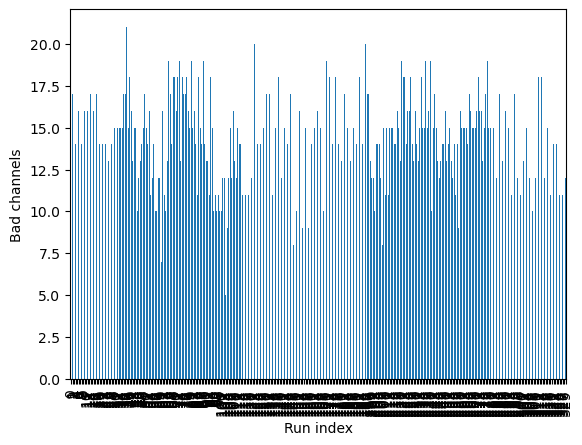

In [35]:
import pandas as pd

df_stats = pd.DataFrame(preproc_stats)
df_stats.to_csv("preprocessing_channel_stats.csv", sep="\t", index=False)

#count of bad chs per run
df_stats["n_bad"].plot(kind="bar")
plt.ylabel("Bad channels")
plt.xlabel("Run index")
plt.show();


In [41]:
# number of good channels = start - bad
df_stats["n_good"] = df_stats["n_channels_start"] - df_stats["n_bad"]

# per-subject averages
df_subj = df_stats.groupby("subject")[["n_bad", "n_good"]].mean()

# mean ± SD across subjects
mean_good = df_subj["n_good"].mean()
std_good  = df_subj["n_good"].std()

mean_bad = df_subj["n_bad"].mean()
std_bad  = df_subj["n_bad"].std()

print(f"Good channels: {mean_good:.1f} ± {std_good:.1f} per subject")
print(f"Bad channels: {mean_bad:.1f} ± {std_bad:.1f} per subject")

Good channels: 50.7 ± 1.3 per subject
Bad channels: 14.3 ± 1.3 per subject


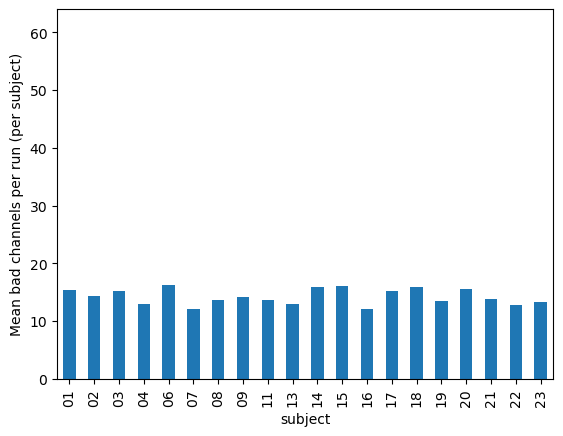

In [37]:
ax = df_stats.groupby("subject")["n_bad"].mean().plot(kind="bar")
ax.set_ylabel("Mean bad channels per run (per subject)")
ax.set_ylim(0, 64)
plt.show()


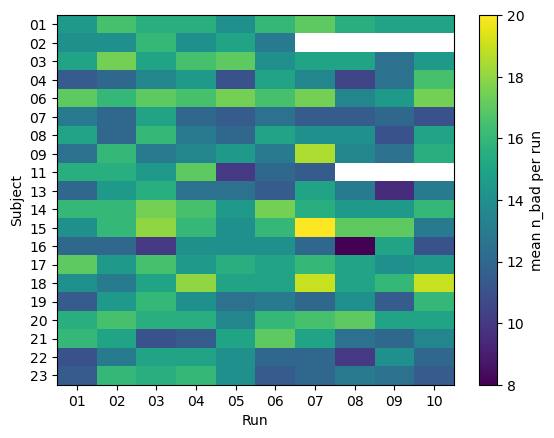

In [36]:
# collapse over sessions: mean n_bad per subject × run
pivot = df_stats.pivot_table(
    index="subject",
    columns="run",
    values="n_bad",
    aggfunc="mean",   # or "sum" if you want total per subject×run
)

plt.imshow(pivot, aspect="auto")
plt.colorbar(label="bad channels per run")
plt.xticks(
    ticks=range(len(pivot.columns)),
    labels=pivot.columns,
)
plt.yticks(
    ticks=range(len(pivot.index)),
    labels=pivot.index,
)
plt.xlabel("Run")
plt.ylabel("Subject")
plt.title("Matrix of bad channels per subject per run")
plt.show()

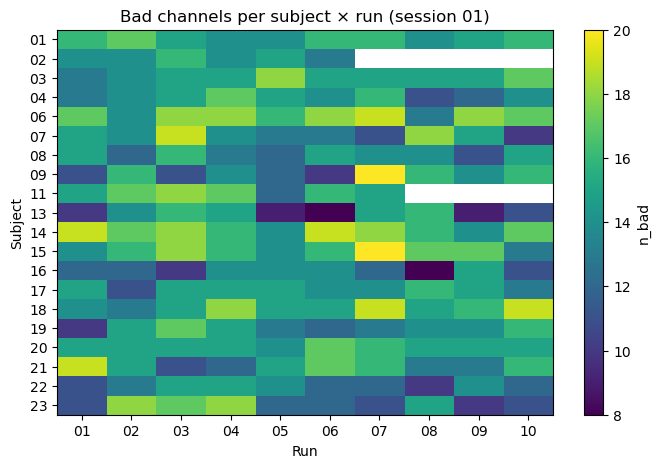

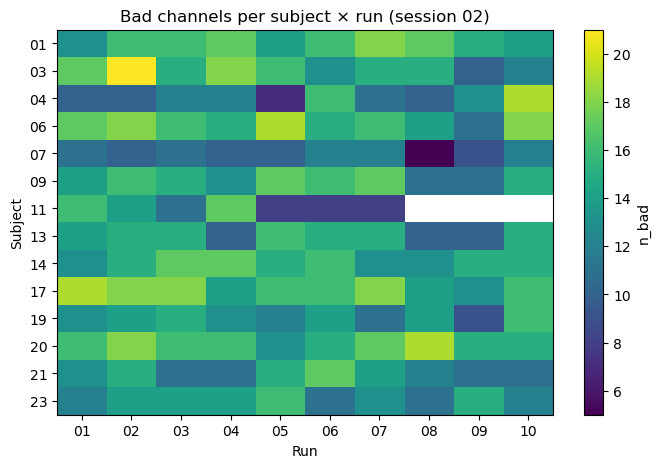

In [37]:
sessions = df_stats["session"].unique()

for ses in sessions:
    df_ses = df_stats[df_stats["session"] == ses]

    # pivot is now valid because (subject, run) pairs are unique within a session
    pivot = df_ses.pivot(index="subject", columns="run", values="n_bad")

    plt.figure(figsize=(8, 5))
    plt.imshow(pivot, aspect="auto")
    plt.colorbar(label="n_bad")
    plt.xticks(
        ticks=range(len(pivot.columns)), 
        labels=pivot.columns
    )
    plt.yticks(
        ticks=range(len(pivot.index)), 
        labels=pivot.index
    )
    plt.title(f"Bad channels per subject × run (session {ses})")
    plt.xlabel("Run")
    plt.ylabel("Subject")
    plt.show()



In [43]:
import os
print(os.getcwd())
os.setcwd


/work/Reka_Clara/reka


In [47]:
import matplotlib.pyplot as plt
from PIL import Image

stim_dir = "../data/ds005107/stimuli/meg/"

fig, axes = plt.subplots(8, 8, figsize=(12, 12))

idx = 0
for row in range(8):
    for col in range(8):
        stim_id = idx + 1
        img_path = os.path.join(stim_dir, f"{stim_id}.bmp")

        ax = axes[row, col]
        ax.axis("off")

        if os.path.exists(img_path):
            img = Image.open(img_path)
            ax.imshow(img, cmap="gray", vmin=0, vmax=255)
            ax.set_title(str(stim_id), fontsize=8)

        idx += 1

plt.tight_layout()
plt.savefig("stimuli_grid.png", dpi=150)

# Epoching the cleaned and filtere raw data (without ICA applied)

In [43]:
tmin = -0.2
tmax = 0.8
epoch_proj_latency = 0.033
import pandas as pd

In [44]:
#load in all behavioural files, from all subjects and all sessions

beh = []  # store all processed raw objects here
data_path = '/work/Reka_Clara/data/ds005107/'

subjects = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
sessions = ['01','02']
runs = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

for subject in subjects:
    for session in sessions:
        for run in runs:
            print(f'Processing behavioural data for subject {subject}, session {session}, run {run}...')
            bids_path = BIDSPath(
                subject=subject,
                session=session,
                task='face',
                run=run,
                datatype='beh',
                suffix='events',
                extension='.tsv',
                root=data_path
            )

            try:
                behv_data = pd.read_csv(bids_path.fpath, sep='\t')
                beh.append(behv_data)
                print(f'Loaded behavioural data for subject {subject}, session {session}, run {run}')

            except Exception as e:
                print(f'Could not load behavioural data for subject {subject}, session {session}, run {run}: {e}')

Processing behavioural data for subject 01, session 01, run 01...
Loaded behavioural data for subject 01, session 01, run 01
Processing behavioural data for subject 01, session 01, run 02...
Loaded behavioural data for subject 01, session 01, run 02
Processing behavioural data for subject 01, session 01, run 03...
Loaded behavioural data for subject 01, session 01, run 03
Processing behavioural data for subject 01, session 01, run 04...
Loaded behavioural data for subject 01, session 01, run 04
Processing behavioural data for subject 01, session 01, run 05...
Loaded behavioural data for subject 01, session 01, run 05
Processing behavioural data for subject 01, session 01, run 06...
Loaded behavioural data for subject 01, session 01, run 06
Processing behavioural data for subject 01, session 01, run 07...
Loaded behavioural data for subject 01, session 01, run 07
Processing behavioural data for subject 01, session 01, run 08...
Loaded behavioural data for subject 01, session 01, run 08


In [46]:

os.makedirs(out_dir, exist_ok=True)
index = 0
all_epochs = []

subject_stats = {}
run_stats = {}


for subject in subjects:
    for session in sessions:
        for run in runs:

            print(f"Processing epochs for subject {subject}, session {session}, run {run}")

            if index >= len(beh):
                print(f"Skipping subject {subject} session {session} run {run}: missing behaviour")
                continue

            bids_path = BIDSPath(
                subject=subject,
                session=session,
                task='face',
                run=run,
                suffix='meg',
                extension='.fif',
                root=data_path
            )

            meg_dir = os.path.join(bids_path.directory, 'derivatives', 'mne-clean')
            clean_fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-clean_meg.fif"
            clean_path  = os.path.join(meg_dir, clean_fname)

            if not os.path.exists(clean_path):
                print(f"Skipping: no clean file {clean_path}")
                continue

            try:
                raw = mne.io.read_raw_fif(clean_path, preload=True, verbose=False)
            except Exception as e:
                print(f"Could not load clean file: {e}")
                continue

            dat_behv = beh[index]

            events = mne.find_events(raw, stim_channel='STIM', shortest_event=1, verbose=False)
        
            include_ids = [1, 44, 55]
            events = mne.pick_events(events, include=include_ids)

            delay_samples = int(round(epoch_proj_latency * raw.info['sfreq']))
            events[:, 0] += delay_samples

            stim_raw = [int(r.split('.')[0][4:]) for r in dat_behv['stim_file']]

            cleaned_stim = []
            keep_idx = []

            for i, s in enumerate(stim_raw):
                if dat_behv['is_oneback'][i] == 1:
                    continue
                if dat_behv['is_oneback'][i] == 0 and dat_behv['is_responsed'][i] == 1:
                    continue
                cleaned_stim.append(s)
                keep_idx.append(i)

            events = events[keep_idx, :]

            ep = mne.Epochs(
                raw,
                events,
                event_id=None,
                tmin=tmin,
                tmax=tmax,
                proj=True,
                baseline=(-0.2, 0),
                reject=None,
                preload=True
            )
            
            #baseline sanity check
            bmask = (ep.times >= -0.2) & (ep.times <= 0.0)
            data = ep.get_data()   # (n_epochs, n_channels, n_times)
            
            # RMS over baseline per epoch/channel
            base_rms = np.sqrt((data[:, :, bmask] ** 2).mean(axis=2))  # (n_epochs, n_channels)
            
            # summarise over epochs to one value per channel
            chan_rms = base_rms.mean(axis=0)  # (n_channels,)
            mean_rms = float(chan_rms.mean())
            std_rms  = float(chan_rms.std())
            
            print(f"[Baseline] sub-{subject} ses-{session} run-{run}: "
                  f"baseline RMS μ={mean_rms:.3e}, σ={std_rms:.3e}")

            picks = mne.pick_types(ep.info, meg=True, stim=False)

            data = ep.get_data()[:, picks, :]      # (epochs, meg_channels, times)
            ptp  = np.ptp(data, axis=2)            # peak-to-peak per epoch × MEG channel
            
            means = ptp.mean(axis=0)
            stds  = ptp.std(axis=0)
            thresh = means + 5.0 * stds            
            
            bad_epochs = (ptp > thresh).any(axis=1)
            
            n_epochs_initial = len(ep)
            ep = ep[~bad_epochs]
            n_epochs_final = len(ep)
            n_dropped = bad_epochs.sum()
            
            print(f"[SimpleReject] dropped {n_dropped} / {n_epochs_initial} epochs")

            #add metadata correctly

            md = pd.DataFrame(dict(stim_id=cleaned_stim))
            md['race']    = ((md.stim_id - 1) // 32) + 1
            md['gender']  = (((md.stim_id - 1) % 32) // 16) + 1
            md['age']     = (((md.stim_id - 1) % 16) // 8) + 1
            md['emotion'] = (((md.stim_id - 1) % 8)  // 4) + 1

            keep = ep.selection
            md = md.iloc[keep].reset_index(drop=True)

            ep.metadata = md


            out_fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif"
            out_path = os.path.join(out_dir, out_fname)
            ep.save(out_path, overwrite=True)

            print(f"Saved epoch file: {out_path}")

            run_key = f"sub-{subject}_ses-{session}_run-{run}"
            run_stats[run_key] = {
                "subject": subject,
                "session": session,
                "run": run,
                "init": n_epochs_initial,
                "dropped": n_dropped,
                "kept": n_epochs_final,
            }

            if subject not in subject_stats:
                subject_stats[subject] = {"init": 0, "dropped": 0, "kept": 0, "runs": 0}
            
            subject_stats[subject]["init"]    += n_epochs_initial
            subject_stats[subject]["dropped"] += n_dropped
            subject_stats[subject]["kept"]    += n_epochs_final
            subject_stats[subject]["runs"]    += 1

            del raw
            del ep

            index += 1

Processing epochs for subject 01, session 01, run 01
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1001 original time points ...
0 bad epochs dropped
[Baseline] sub-01 ses-01 run-01: baseline RMS μ=6.201e-03, σ=4.961e-02
[SimpleReject] dropped 4 / 256 epochs
Adding metadata with 5 columns
Overwriting existing file.
Overwriting existing file.
Overwriting existing file.
Saved epoch file: /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-01_proc-epo.fif
Processing epochs for subject 01, session 01, run 02
Not setting metadata
256 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 256 events and 1001 original time points ...
0 bad epochs dropped
[Baseline] sub-01 ses-01 run-02: baseline RMS μ=6.613e-03, σ=5.290e-02
[SimpleReject] dropped 3 / 256 epochs
Adding metadata 

In [47]:

df_subj = pd.DataFrame.from_dict(subject_stats, orient="index")
df_subj.index.name = "subject"
df_subj.reset_index(inplace=True)

df_subj["avg_dropped"] = df_subj["dropped"] / df_subj["runs"]




[Epoch summary per subject]


NameError: name 'epoch_stats' is not defined

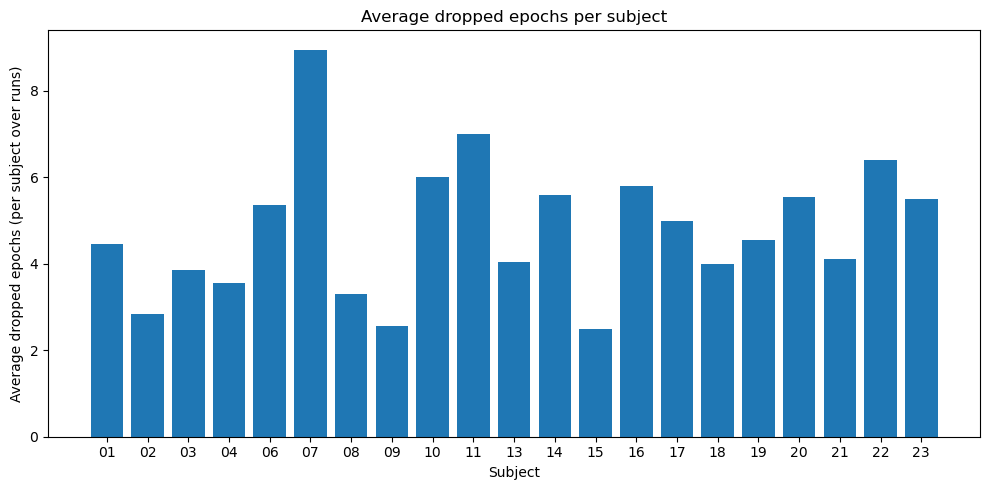

In [48]:
df_subj = pd.DataFrame.from_dict(subject_stats, orient="index")
df_subj.index.name = "subject"
df_subj.reset_index(inplace=True)

df_subj["avg_dropped"] = df_subj["dropped"] / df_subj["runs"]

plt.figure(figsize=(10,5))
plt.bar(df_subj["subject"], df_subj["avg_dropped"])
plt.xlabel("Subject")
plt.ylabel("Average dropped epochs (per subject over runs)")
plt.title("Average dropped epochs per subject")
plt.tight_layout()
plt.show()


In [51]:
#print(df_subj)

total_epochs = df_subj["init"].sum()

dropped_epochs = df_subj["dropped"].sum()

kept_epochs    = df_subj["kept"].sum()

print("Total epochs:", total_epochs)
print("Dropped epochs:", dropped_epochs)
print("Kept epochs:", kept_epochs)



Total epochs: 86402
Dropped epochs: 1644
Kept epochs: 84758


In [52]:
import numpy as np

def compute_snr(ep, tmin_signal=0.0, tmax_signal=0.3):
    """
    Computes SNR = RMS(post-stimulus) / RMS(baseline) for each channel.
    """
    data = ep.get_data()  # (n_epochs, n_channels, n_times)
    times = ep.times

    # baseline mask
    bmask = (times >= -0.2) & (times <= 0.0)

    # signal window mask
    smask = (times >= tmin_signal) & (times <= tmax_signal)

    baseline_rms = np.sqrt((data[:, :, bmask] ** 2).mean(axis=2))   # per epoch × channel
    signal_rms   = np.sqrt((data[:, :, smask] ** 2).mean(axis=2))

    # average over epochs
    baseline_rms = baseline_rms.mean(axis=0)
    signal_rms   = signal_rms.mean(axis=0)

    snr = signal_rms / baseline_rms
    return snr

In [55]:


snr_all = []

for subject in subjects:
    for session in sessions:
        for run in runs:

            fname = f"sub-{subject}_ses-{session}_task-face_run-{run}_proc-epo.fif"
            full_path = os.path.join(out_dir, fname)

            if not os.path.exists(full_path):
                continue  # skip missing runs

            ep = mne.read_epochs(full_path, preload=True)
            snr = compute_snr(ep)

            snr_all.append({
                "subject": subject,
                "session": session,
                "run": run,
                "mean_snr": snr.mean()
            })


Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-01_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-02_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
253 matching events found
No baseline correction applied
0 projection items activated
Reading /work/Reka_Clara/data/ds005107/derivatives/epochs/sub-01_ses-01_task-face_run-03_proc-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
252 ma

In [58]:

df_snr = pd.DataFrame(snr_all)
#print(df_snr)

mean_snr = df_snr["mean_snr"].mean()
sd_snr   = df_snr["mean_snr"].std()

print(f"Mean SNR across all runs: {mean_snr:.4f}")
print(f"Standard deviation:       {sd_snr:.4f}")

Mean SNR across all runs: 1.5977
Standard deviation:       0.0731
